#Práctica 3: Análisis de Series Temporales
###*Técnicas Avanzadas de Análisis de Datos*, Máster Universitario en Ciberseguridad e Inteligencia de Datos.
####*Alba Cruz Torres*

## Accidentes de avión y víctimas mortales desde 1908.

<p align="justify">Para el desempeño de esta práctica, se debe realizar el análisis de una serie temporal concreta. Una serie temporal es una sucesión de datos medidos en determinados momentos y ordenados cronológicamente. Lo que se desea conseguir es hacer uso de métodos que ayuden a su interpretación y a la extracción de la mayor cantidad de información representativa posible.</p>
<p align="justify">Para este proyecto, se ha decidido utilizar un conjunto de datos sobre la evolución de los accidentes aéreos desde 1908 hasta 2009. Con el análisis de este <i>dataset</i> se pretende conseguir dar respuesta a las siguientes preguntas: </p>

<ul align="justify">
  <li>¿Cómo han evolucionado a lo largo del tiempo?</li>
  <li>¿Tienen que ver con la zona?</li>
  <li>¿Qué aerolíneas han sufrido más accidentes de avión? ¿Cuáles han causado más víctimas mortales?</li>
  <li>¿En qué año se estima llegar a 0 accidentes?</li>
  <li>¿Han disminuido los accidentes con el avance de las tecnologías?</li>
</ul>
<p align="justify">Además, no solo se pretende contestar a estas preguntas y más que vayan surgiendo, sino que se tiene como objetivo el ampliar el conocimiento y el entendimiento de la causa y predisposiciones de los accidentes con el paso del tiempo.</p>


### Importación de paquetes

<p align="justify">En primer lugar, se procede a la instalación e importación de paquetes y librerías.</p>

In [1]:
!pip3 install pmdarima

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.8 MB 12.3 MB/s 
     |████████████████████████████████| 9.8 MB 65.2 MB/s 
  Attempting uninstall: statsmodels
    Found existing installation: statsmodels 0.12.2
    Uninstalling statsmodels-0.12.2:
      Successfully uninstalled statsmodels-0.12.2


In [2]:
#importing the libraries and data
import io
import numpy as np 
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import date, timedelta, datetime
import matplotlib.pylab as pl
import matplotlib.gridspec as gridspec
from pandas.plotting import autocorrelation_plot
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf
from statsmodels.tsa.arima.model import ARIMA
from pmdarima.arima import ADFTest
from pmdarima.arima import auto_arima
from sklearn.metrics import mean_squared_error
from math import sqrt
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

### Carga de datos

<p align="justify">El siguiente paso es el de cargar el conjunto de datos con el que se va a trabajar. En este caso, dicho conjunto de datos es el denominado "<i>Airplane_Crashes_and_Fatalities_Since_1908</i>", en el que se encuentra información de los accidentes de avión ocurridos desde 1908 hasta 2009 y en el que se detallan datos sobre el número de víctimas causadas, la compañía, el tipo de avión, el número de pasajeros a bordo o un resumen del accidente.</p>

In [3]:
from google.colab import files
uploaded = files.upload()

Saving Airplane_Crashes_and_Fatalities_Since_1908.csv to Airplane_Crashes_and_Fatalities_Since_1908.csv


In [4]:
df = pd.read_csv(io.BytesIO(uploaded['Airplane_Crashes_and_Fatalities_Since_1908.csv']))

### Análisis Exploratorio

<p align="justify">A continuación, se procede a realizar un análisis exploratorio del conjunto de datos, en el que se estudiará la estructura de los datos, se analizarán los valores nulos o perdidos y cómo manejarlos y se hará una representación gráfica de los datos que permita entender qué información aportan y resolver algunas de las preguntas a las que se desea dar respuesta.</p>

#### Estructura de los datos

<p align="justify">Como se puede ver en la siguiente tabla, el <i>dataset</i> está formado por 13 columnas que contienen información relativa al accidente:</p>

<ul type="1" align="justify">
  <li><i>Date</i>: Fecha</li>
  <li><i>Time</i>: Hora local</li>
  <li><i>Location</i>: Lugar del accidente</li>
  <li><i>Operator</i>: Operador o aerolínea del vuelo</li>
  <li><i>Flight #</i>: Número de vuelo</li>
  <li><i>Route</i>: Ruta completa o parcial realizada hasta el momento del accidente</li>
  <li><i>Type</i>: Tipo de aeronave</li>
  <li><i>Registration</i>: Registro ICAO de la aeronave</li>
  <li><i>cn/In</i>: Número de serie o construcción / Número de fuselaje</li>
  <li><i>Aboard</i>: Número de pasajeros y tripulación a bordo</li>
  <li><i>Fatalities</i>: Número de víctimas mortales</li>
  <li><i>Ground</i>: Número de fallecidos en tierra</li>
  <li><i>Summary</i>: Breve descripción del accidente y causa si es conocida</li>
</ul>

In [5]:
df.head(5)

,Date,Time,Location,Operator,Flight #,Route,Type,Registration,cn/In,Aboard,Fatalities,Ground,Summary
0,09/17/1908,17:18,"Fort Myer, Virginia",Military - U.S. Army,NaN,Demonstration,Wright Flyer III,NaN,1,2.0,1.0,0.0,"During a demonstration flight, a U.S. Army fly..."
1,07/12/1912,06:30,"AtlantiCity, New Jersey",Military - U.S. Navy,NaN,Test flight,Dirigible,NaN,NaN,5.0,5.0,0.0,First U.S. dirigible Akron exploded just offsh...
2,08/06/1913,NaN,"Victoria, British Columbia, Canada",Private,-,NaN,Curtiss seaplane,NaN,NaN,1.0,1.0,0.0,The first fatal airplane accident in Canada oc...
3,09/09/1913,18:30,Over the North Sea,Military - German Navy,NaN,NaN,Zeppelin L-1 (airship),NaN,NaN,20.0,14.0,0.0,The airship flew into a thunderstorm and encou...
4,10/17/1913,10:30,"Near Johannisthal, Germany",Military - German Navy,NaN,NaN,Zeppelin L-2 (airship),NaN,NaN,30.0,30.0,0.0,Hydrogen gas which was being vented was sucked...


<p align="justify">Para poder ver el resumen del accidente entero, se ejecuta el siguiente comando que permite su representación completa.</p>

In [6]:
pd.set_option('display.max_colwidth', -1)

In [7]:
df.head(5)

,Date,Time,Location,Operator,Flight #,Route,Type,Registration,cn/In,Aboard,Fatalities,Ground,Summary
0,09/17/1908,17:18,"Fort Myer, Virginia",Military - U.S. Army,NaN,Demonstration,Wright Flyer III,NaN,1,2.0,1.0,0.0,"During a demonstration flight, a U.S. Army flyer flown by Orville Wright nose-dived into the ground from a height of approximately 75 feet, killing Lt. Thomas E. Selfridge who was a passenger. This was the first recorded airplane fatality in history. One of two propellers separated in flight, tearing loose the wires bracing the rudder and causing the loss of control of the aircraft. Orville Wright suffered broken ribs, pelvis and a leg. Selfridge suffered a crushed skull and died a short time later."
1,07/12/1912,06:30,"AtlantiCity, New Jersey",Military - U.S. Navy,NaN,Test flight,Dirigible,NaN,NaN,5.0,5.0,0.0,"First U.S. dirigible Akron exploded just offshore at an altitude of 1,000 ft. during a test flight."
2,08/06/1913,NaN,"Victoria, British Columbia, Canada",Private,-,NaN,Curtiss seaplane,NaN,NaN,1.0,1.0,0.0,"The first fatal airplane accident in Canada occurred when American barnstormer, John M. Bryant, California aviator was killed."
3,09/09/1913,18:30,Over the North Sea,Military - German Navy,NaN,NaN,Zeppelin L-1 (airship),NaN,NaN,20.0,14.0,0.0,The airship flew into a thunderstorm and encountered a severe downdraft crashing 20 miles north of Helgoland Island into the sea. The ship broke in two and the control car immediately sank drowning its occupants.
4,10/17/1913,10:30,"Near Johannisthal, Germany",Military - German Navy,NaN,NaN,Zeppelin L-2 (airship),NaN,NaN,30.0,30.0,0.0,"Hydrogen gas which was being vented was sucked into the forward engine and ignited causing the airship to explode and burn at 3,000 ft.."


<p align="justify">Con el siguiente comando se puede hacer una observación de los valores medios, máximos y mínimos de las variables numéricas sobre las que se va a centrar el foco a lo largo de este proyecto. Por tanto, se puede ver que la media de los pasajeros a bordo en los accidentes, contando con la tripulación, ha sido de 27.55 personas por aeronave. Además, se muestra el máximo y el mínimo de los pasajeros a bordo, de las víctimas mortales del accidente y de los fallecidos en tierra a causa del accidente. Como se puede observar, los valores máximos son bastante críticos y preocupantes, pues se trata de 583 víctimas mortales y de 2750 fallecidos en tierra.</p>

In [8]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Aboard,5246.0,27.554518,43.076711,0.0,5.0,13.0,30.0,644.0
Fatalities,5256.0,20.068303,33.199952,0.0,3.0,9.0,23.0,583.0
Ground,5246.0,1.608845,53.987827,0.0,0.0,0.0,0.0,2750.0


<p align="justify">Si se hace un análisis de los accidentes que ocasionaron ese número de fallecidos tan alto, se tiene, en primer lugar, el ataque terrorista hacia lo que se conoce como las <i>Torres Gemelas</i> o <i>World Trade Center</i>. Dicho ataque dio pie no solo al fallecimiento de los 175 pasajeros y tripulantes de los aviones en cuestión, sino que también causó la muerte de 2750 civiles en tierra.</p>

In [9]:
df.loc[df['Ground'] == 2750.0]

,Date,Time,Location,Operator,Flight #,Route,Type,Registration,cn/In,Aboard,Fatalities,Ground,Summary
4803,09/11/2001,08:47,"New York City, New York",American Airlines,11,Boston - Los Angeles,Boeing 767-223ER,N334AA,22332/169,92.0,92.0,2750.0,"The aircraft was hijacked shortly after it left Logan International Airport in Boston. The hijackers took control of the aircraft and deliberately crashed it into the north tower of the World Trade Center between the 94th and 99th floors at approximately 450 mph. After 102 minutes, the building collapsed. It was one of four planes that were hijacked the same day."
4804,09/11/2001,09:03,"New York City, New York",United Air Lines,175,Boston - Los Angeles,Boeing B-767-222,N612UA,21873/41,65.0,65.0,2750.0,"The aircraft was hijacked shortly after it left Logan International Airport in Boston. The hijackers took control of the aircraft and deliberately crashed it into the south tower of the World Trade Center between the 78th and 84th floors at approximately 550 mph. After 56 minutes, the building collapsed. It was one of four planes that were hijacked the same day."


<p align="justify">Por otro lado, se encuentra el accidente de avión que causó el mayor número de víctimas mortales, contando tanto con pasajeros como con tripulación. Este accidente, conocido como <i>Desastre aéreo de Tenerife</i>, fue el ocurrido en 1977 en esta isla, en el que dos aviones colisionaron, puesto que, mientras uno iniciaba su carrera de despegue, el otro aún se encontraba en la pista, envuelto en la niebla. Ha sido el accidente más catastrófico en una colisión en tierra y el más mortífero en España.</p>

In [10]:
df.loc[df['Fatalities'] == 583.0]

,Date,Time,Location,Operator,Flight #,Route,Type,Registration,cn/In,Aboard,Fatalities,Ground,Summary
2963,03/27/1977,17:07,"Tenerife, Canary Islands",Pan American World Airways / KLM,1736/4805,Tenerife - Las Palmas / Tenerife - Las Palmas,Boeing B-747-121 / Boeing B-747-206B,N736PA/PH-BUF,19643/11 / 20400/157,644.0,583.0,0.0,"Both aircraft were diverted to Tenerife because of a bombing at Las Palmas Airport. After an extended delay, both planes were instructed to back track up the runway. The KLM plane reached its takeoff point while the Pan Am plane was still on the runway. The Pan Am plane continued up the runway missing the taxiway turnout. There was heavy fog on the runway. The KLM plane began its takeoff roll without permission with the Pan Am plane still on the runway. The KLM plane hit the Pan Am plane just as it was taking off. Both planes burst into flames. KLM 234 + 14 crew, Pan Am 326 + 9 crew killed. All aboard the KLM plane were killed. The Pan Am aircraft was named Clipper Victor. The KLM aircraft was named Rhine River."


#### Representación de datos en gráficas

<p align="justify">A continuación, se procede a la representación gráfica de los datos almacenados en el <i>dataset</i>, con el fin de comprender qué información aportan y qué preguntas se podrán resolver con dichos datos. Ya que se trata de una serie temporal, la fecha y hora del accidente se debe expresar como un <i>datetime</i>, es decir, con el siguiente formato: aaaa/mm/dd 00:00:00. Para ello, se ha hecho uso de la siguiente función, que convierte tanto la fecha como la hora a dicho formato y los une en la columna '<i>Time</i>'. Como se puede observar, el rango de fechas va desde el 17-09-1908 hasta el 08-06-2009.</p>

In [11]:
df['Time'] = df['Time'].replace(np.nan, '00:00') 
df['Time'] = df['Time'].str.replace('c: ', '')
df['Time'] = df['Time'].str.replace('c:', '')
df['Time'] = df['Time'].str.replace('c', '')
df['Time'] = df['Time'].str.replace('12\'20', '12:20')
df['Time'] = df['Time'].str.replace('18.40', '18:40')
df['Time'] = df['Time'].str.replace('0943', '09:43')
df['Time'] = df['Time'].str.replace('22\'08', '22:08')
df['Time'] = df['Time'].str.replace('114:20', '00:00') 

df['Time'] = df['Date'] + ' ' + df['Time'] 
def todate(x):
    return datetime.strptime(x, '%m/%d/%Y %H:%M')
df['Time'] = df['Time'].apply(todate) #convert to date type
print('Date ranges from ' + str(df.Time.min()) + ' to ' + str(df.Time.max()))

df.Operator = df.Operator.str.upper() #just to avoid duplicates like 'British Airlines' and 'BRITISH Airlines'

Date ranges from 1908-09-17 17:18:00 to 2009-06-08 00:00:00


Después de haber realizado esta transformación, se puede ver claramente, cómo la columna <i>Time</i> ha cambiado de tener simplemente la hora local del accidente, a almacenar tanto la fecha como la hora en el formato adecuado.

In [12]:
df.head(5)

,Date,Time,Location,Operator,Flight #,Route,Type,Registration,cn/In,Aboard,Fatalities,Ground,Summary
0,09/17/1908,1908-09-17 17:18:00,"Fort Myer, Virginia",MILITARY - U.S. ARMY,NaN,Demonstration,Wright Flyer III,NaN,1,2.0,1.0,0.0,"During a demonstration flight, a U.S. Army flyer flown by Orville Wright nose-dived into the ground from a height of approximately 75 feet, killing Lt. Thomas E. Selfridge who was a passenger. This was the first recorded airplane fatality in history. One of two propellers separated in flight, tearing loose the wires bracing the rudder and causing the loss of control of the aircraft. Orville Wright suffered broken ribs, pelvis and a leg. Selfridge suffered a crushed skull and died a short time later."
1,07/12/1912,1912-07-12 06:30:00,"AtlantiCity, New Jersey",MILITARY - U.S. NAVY,NaN,Test flight,Dirigible,NaN,NaN,5.0,5.0,0.0,"First U.S. dirigible Akron exploded just offshore at an altitude of 1,000 ft. during a test flight."
2,08/06/1913,1913-08-06 00:00:00,"Victoria, British Columbia, Canada",PRIVATE,-,NaN,Curtiss seaplane,NaN,NaN,1.0,1.0,0.0,"The first fatal airplane accident in Canada occurred when American barnstormer, John M. Bryant, California aviator was killed."
3,09/09/1913,1913-09-09 18:30:00,Over the North Sea,MILITARY - GERMAN NAVY,NaN,NaN,Zeppelin L-1 (airship),NaN,NaN,20.0,14.0,0.0,The airship flew into a thunderstorm and encountered a severe downdraft crashing 20 miles north of Helgoland Island into the sea. The ship broke in two and the control car immediately sank drowning its occupants.
4,10/17/1913,1913-10-17 10:30:00,"Near Johannisthal, Germany",MILITARY - GERMAN NAVY,NaN,NaN,Zeppelin L-2 (airship),NaN,NaN,30.0,30.0,0.0,"Hydrogen gas which was being vented was sucked into the forward engine and ignited causing the airship to explode and burn at 3,000 ft.."


<p align="justify">Ahora, se va a representar de manera gráfica el número de accidentes por año. Con dicha gráfica, se puede observar el flujo de los accidentes aéreos según los años en los que se registraron. Entre los años 60 y 80 se registró el mayor número de accidentes.</p>

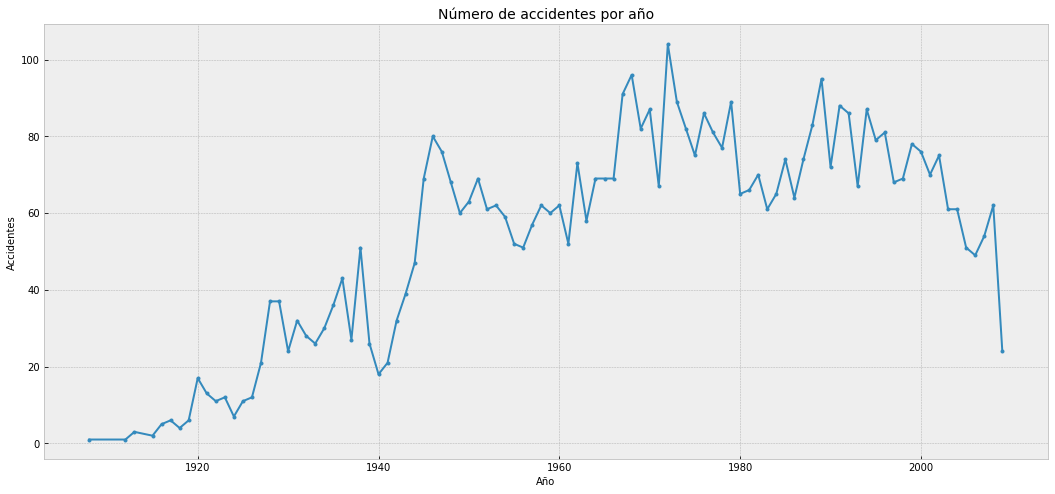

In [13]:
year_count = df.groupby(df.Time.dt.year)[['Date']].count() 
year_count = year_count.rename(columns={"Date": "Count"})

plt.figure(figsize=(18,8))
plt.style.use('bmh')
plt.plot(year_count.index, 'Count', data=year_count, marker = ".")
plt.xlabel('Año', fontsize=10)
plt.ylabel('Accidentes', fontsize=10)
plt.title('Número de accidentes por año', loc='Center', fontsize=14)
plt.show()

<p align="justify">Como se puede observar a continuación, el año en que hubo un mayor número de accidentes fue el año 1972 con 104 accidentes, seguido del año 1968 en el que sucedieron 96 accidentes.</p>

In [14]:
temp = year_count.sort_values(by='Count', ascending=False)
temp.head()

,Count
Time,
1972,104
1968,96
1989,95
1967,91
1979,89


A continuación, se procede a mostrar de manera gráfica, la cantidad de víctimas mortales causadas por accidentes aéreos por año. Al igual que la gráfica anterior, entre la década de los 60 y 80 hubo más víctimas mortales.

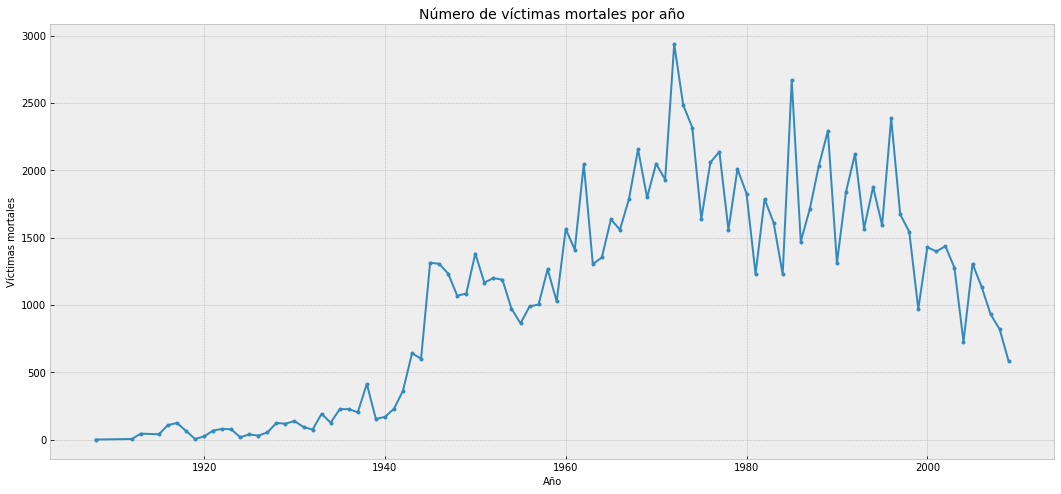

In [15]:
year_sum = df.groupby(df.Time.dt.year)[['Fatalities']].sum() 
year_sum = year_sum.rename(columns={"Fatalities": "Count"})

plt.figure(figsize=(18,8))
plt.style.use('bmh')
plt.plot(year_sum.index, 'Count', data=year_sum, marker = ".")
plt.xlabel('Año', fontsize=10)
plt.ylabel('Víctimas mortales', fontsize=10)
plt.title('Número de víctimas mortales por año', loc='Center', fontsize=14)
plt.show()

En ambos casos, el año 1972 es el más crítico en cuanto a accidentes y víctimas mortales se refiere. En este año, fallecieron 2937 personas en total a causa de los accidentes aéreos.

In [16]:
temp = year_sum.sort_values(by='Count', ascending=False)
temp.head()

,Count
Time,
1972,2937.0
1985,2670.0
1973,2485.0
1996,2386.0
1974,2318.0


In [17]:
df[(df.Time.dt.year==1972)][['Location', 'Fatalities', 'Summary']].head(10).sort_values(by='Fatalities', ascending=False)

,Location,Fatalities,Summary
2518,"Sierra de Atalayasa, Spain",104.0,The aircraft crashed into hill while attempting to land. Failure to maintain the minimum flight altitude during the final stages of the visual approach.
2522,"Near Betania, Colombia",39.0,The aircraft struck a mountain in rain and thunderstorms operating as a non-scheduled passenger airliner run by the military.
2523,"Near Hermsdorf, Czechoslovakia",27.0,"The plane crashed after the detonation of a bomb in the forward cargo hold. A flight attendant, 22 year old Vesna Vulovic, fell 33,330 feet in the tail section and although she broke both legs and was temporarily paralyzed from the waist down, she survived. She was in a coma for 27 days and it took 16 months for her to recover. The bomb was believed to be placed on the plane by a Croatian extremist group. On January 27, 1997, 25 years after the crash, Vesna Vulovireturned to the crash-site and was reunited with the firemen who pulled her from the wreckage and the medical team who looked after her in the hospital."
2517,"Near Chetumal, Mexico",23.0,The aircraft crashed following a fire onboard while en route.
2521,"Near Funza, Colombia",20.0,Crashed shortly after leaving Bogota after an explosion aboard.
2524,"Near Tegal, Indonesia",6.0,Due to a compass error the aircraft became lost and crashed during a forced landing due to fuel starvation.
2519,"Chambers, Nebraska",3.0,"The pilot feathered the right engine for undetermined reasons, failed to maintain safe altitude and crashed into a telephone pole and wires."
2526,"BattleMountain, Nevada",2.0,Pilot flying too high and suffered hypoxia. Pilot had emphysema and advanced arteriosclerosis. No oxygen aboard the aircraft.
2520,"Near Adana, Turkey",1.0,"After diverting to Adana because of pressurization problems, the aircraft hit the ground downwind on the second approach and caught fire."
2525,"Pha Khao, Laos",1.0,Crashed while attempting to land. Overloaded


<p align="justify">Asimismo, se ha decidido hacer unos gráficos de barras en los que se muestran cuántos accidentes han sucedido según el mes, el día y la hora. En el gráfico siguiente es observable que el mes en el que han ocurrido más accidentes a lo largo de estos 101 años de registros, ha sido el mes de diciembre. Por otro lado, el día de la semana en el que han sucedido más accidentes ha sido el jueves. Finalmente, la hora en la que se han registrado más accidentes ha sido en torno a las 9:00 am.</p>

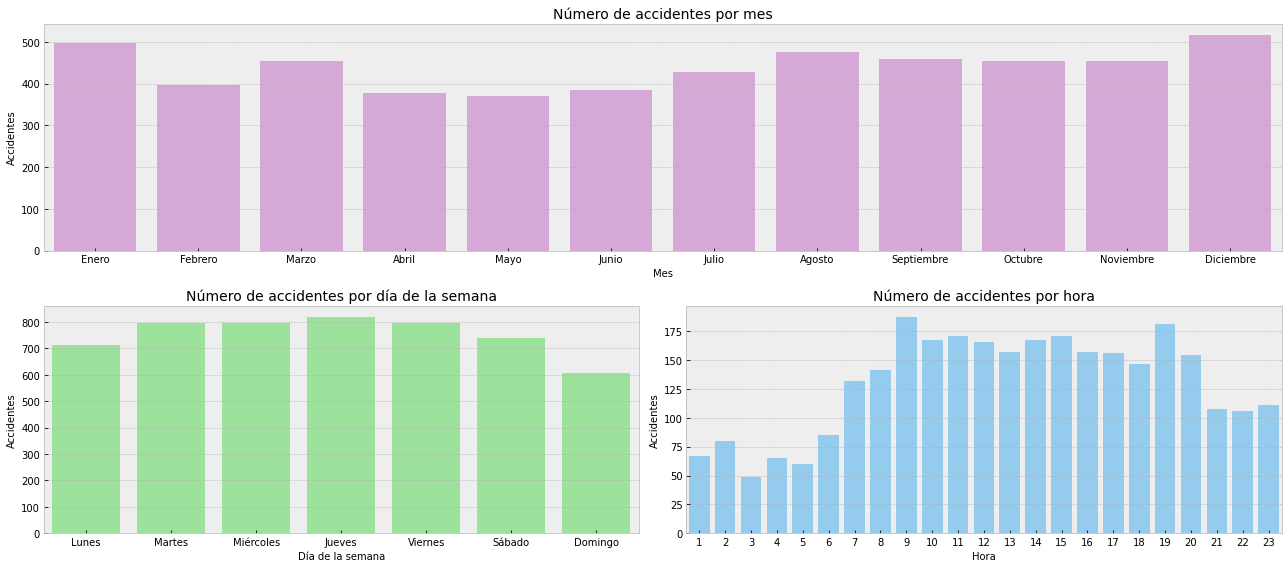

In [18]:
gs = gridspec.GridSpec(2, 2)
pl.figure(figsize=(18,8))
plt.style.use('seaborn-muted')
ax = pl.subplot(gs[0, :])
sns.barplot(df.groupby(df.Time.dt.month)[['Date']].count().index, 'Date', data=df.groupby(df.Time.dt.month)[['Date']].count(), color ='plum', linewidth=2)
plt.xticks(df.groupby(df.Time.dt.month)[['Date']].count().index-1, ['Enero', 'Febrero', 'Marzo', 'Abril', 'Mayo', 'Junio', 'Julio', 'Agosto', 'Septiembre', 'Octubre', 'Noviembre', 'Diciembre'])
plt.xlabel('Mes', fontsize=10)
plt.ylabel('Accidentes', fontsize=10)
plt.title('Número de accidentes por mes', loc='Center', fontsize=14)

ax = pl.subplot(gs[1, 0])
sns.barplot(df.groupby(df.Time.dt.weekday)[['Date']].count().index, 'Date', data=df.groupby(df.Time.dt.weekday)[['Date']].count(), color ='lightgreen', linewidth=2)
plt.xticks(df.groupby(df.Time.dt.weekday)[['Date']].count().index, ['Lunes', 'Martes', 'Miércoles', 'Jueves', 'Viernes', 'Sábado', 'Domingo'])
plt.xlabel('Día de la semana', fontsize=10)
plt.ylabel('Accidentes', fontsize=10)
plt.title('Número de accidentes por día de la semana', loc='Center', fontsize=14)

ax = pl.subplot(gs[1, 1])
sns.barplot(df[df.Time.dt.hour != 0].groupby(df.Time.dt.hour)[['Date']].count().index, 'Date', data=df[df.Time.dt.hour != 0].groupby(df.Time.dt.hour)[['Date']].count(), color ='lightskyblue', linewidth=2) #color ='lightskyblue'
plt.xlabel('Hora', fontsize=10)
plt.ylabel('Accidentes', fontsize=10)
plt.title('Número de accidentes por hora', loc='Center', fontsize=14)
plt.tight_layout()
plt.show()


<p align="justify">El siguiente paso es el de contabilizar y representar gráficamente el número de fallecidos y supervivientes frente a los pasajeros y tripulación a bordo de la aeronave. Como se puede observar en la imagen siguiente, en la totalidad de los accidentes aéreos registrados se muestra que solo un 27% de los pasajeros sobrevivieron a los accidentes, mientras que el 73% restante fallecieron.</p>

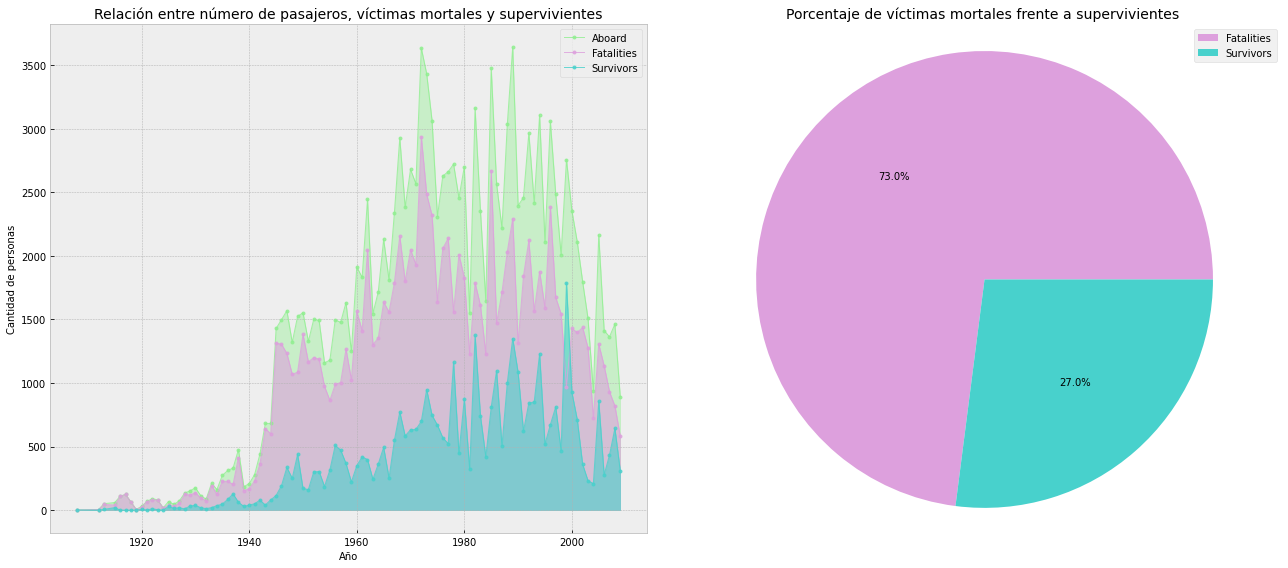

In [19]:
Accidents = df.groupby(df.Time.dt.year).sum()
Accidents['Survivors'] = Accidents['Aboard'] - Accidents['Fatalities']

plt.figure(figsize=(18,8))
plt.subplot(1, 2, 1)
plt.fill_between(Accidents.index, 'Aboard', data=Accidents, color="lightgreen", alpha=0.4)
plt.plot(Accidents.index, 'Aboard', data=Accidents, marker = ".", color="lightgreen", alpha=0.8, linewidth=1)
plt.fill_between(Accidents.index, 'Fatalities', data=Accidents, color="plum", alpha=0.6)
plt.plot(Accidents.index, 'Fatalities', data=Accidents, color="plum", marker = ".", alpha=0.8, linewidth=1)
plt.fill_between(Accidents.index, 'Survivors', data=Accidents, color="mediumturquoise", alpha=0.6)
plt.plot(Accidents.index, 'Survivors', data=Accidents, color="mediumturquoise", marker = ".", alpha=0.8, linewidth=1)
plt.legend(fontsize=10)
plt.xlabel('Año', fontsize=10)
plt.ylabel('Cantidad de personas', fontsize=10)
plt.title('Relación entre número de pasajeros, víctimas mortales y supervivientes', loc='Center', fontsize=14)

plt.subplot(1, 2, 2)
Aboard = df.Aboard.sum()
Fatalities = df.Fatalities.sum()
Survivors = Aboard - Fatalities

y = np.array([Fatalities, Survivors])
mylabels = ["Fatalities", "Survivors"]
colors = ["plum", "mediumturquoise"]
plt.pie(y, autopct='%1.1f%%', colors=colors)
plt.legend(labels=mylabels)
plt.axis('equal')
plt.title('Porcentaje de víctimas mortales frente a supervivientes', loc='Center', fontsize=14)
plt.tight_layout()
plt.show()

In [20]:
Accidents[['Aboard', 'Fatalities', 'Survivors']].head(10)

,Aboard,Fatalities,Survivors
Time,,,
1908,2.0,1.0,1.0
1912,5.0,5.0,0.0
1913,51.0,45.0,6.0
1915,60.0,40.0,20.0
1916,109.0,108.0,1.0
1917,124.0,124.0,0.0
1918,65.0,65.0,0.0
1919,5.0,5.0,0.0
1920,31.0,24.0,7.0


<p align="justify">Ahora, se procede a la comparación del número de accidentes según el tipo de vuelo, es decir, según si era un vuelo de pasajeros o un vuelo militar. Como se observa en el siguiente gráfico, la gran cantidad de vuelos accidentados fueron vuelos de pasajeros, en concreto, 4469 vuelos de pasajeros sufrieron un accidente aéreo, mientras que fueron 781 los vuelos militares que resultaron accidentados.</p>

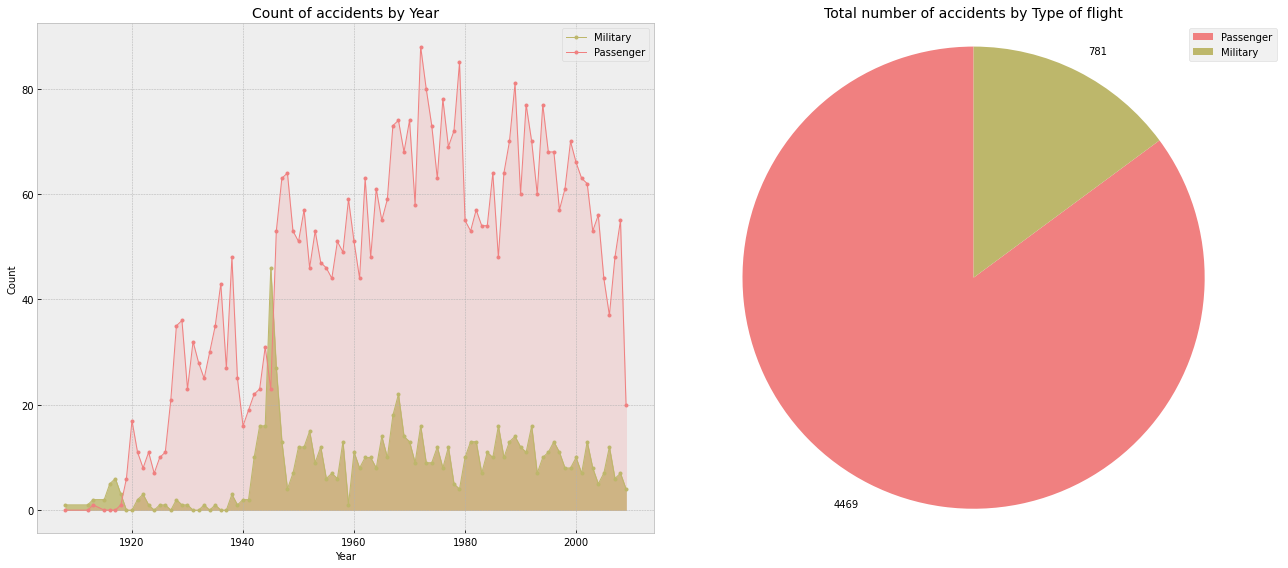

In [21]:
Temp = df.copy()
Temp['isMilitary'] = Temp.Operator.str.contains('MILITARY')
Temp = Temp.groupby('isMilitary')[['isMilitary']].count()
Temp.index = ['Passenger', 'Military']

Temp2 = df.copy()
Temp2['Military'] = Temp2.Operator.str.contains('MILITARY')
Temp2['Passenger'] = Temp2.Military == False
Temp2 = Temp2.loc[:, ['Time', 'Military', 'Passenger']]
Temp2 = Temp2.groupby(Temp2.Time.dt.year)[['Military', 'Passenger']].aggregate(np.count_nonzero)

plt.figure(figsize=(18,8))

colors = ['lightcoral', 'darkkhaki']
plt.subplot(1, 2, 2)
patches, texts = plt.pie(Temp.isMilitary, colors=colors, labels=Temp.isMilitary, startangle=90)
plt.legend(patches, Temp.index, loc="best", fontsize=10)
plt.axis('equal')
plt.title('Total number of accidents by Type of flight', loc='Center', fontsize=14)

plt.subplot(1, 2, 1)
plt.fill_between(Temp2.index, 'Military', data=Temp2, color="darkkhaki", alpha=0.8)
plt.plot(Temp2.index, 'Military', data=Temp2, color='darkkhaki', marker = ".", linewidth=1)
plt.fill_between(Temp2.index, 'Passenger', data=Temp2, color="lightcoral", alpha=0.2)
plt.plot(Temp2.index, 'Passenger', data=Temp2, color='lightcoral', marker = ".", linewidth=1)
plt.legend(fontsize=10)
plt.xlabel('Year', fontsize=10)
plt.ylabel('Count', fontsize=10)
plt.title('Count of accidents by Year', loc='Center', fontsize=14)
plt.tight_layout()
plt.show()

<p align="justify">Ahora, se procede a visualizar la cantidad de accidentes aéreos causados por cada compañía. Al tratarse de una gran cantidad de ellas, se ha decidido evaluar el <i>top 10</i>, puesto que se tiene especial interés en las que han causado mayores números de accidentes y fallecimientos. De esta manera, se puede observar que la aerolínea con más accidentes a sus espaldas es la compañía rusa <i>Aeroflot</i>, con un total de 179 accidentes, seguida muy de cerca por la compañía militar <i>U.S. Air Force</i>, siendo la causante de 176 accidentes.</p>

                                     Count
Operator                                  
AEROFLOT                             179  
MILITARY - U.S. AIR FORCE            176  
AIR FRANCE                           70   
DEUTSCHE LUFTHANSA                   65   
AIR TAXI                             48   
CHINA NATIONAL AVIATION CORPORATION  44   
UNITED AIR LINES                     44   
MILITARY - U.S. ARMY AIR FORCES      43   
PAN AMERICAN WORLD AIRWAYS           41   
US AERIAL MAIL SERVICE               36    



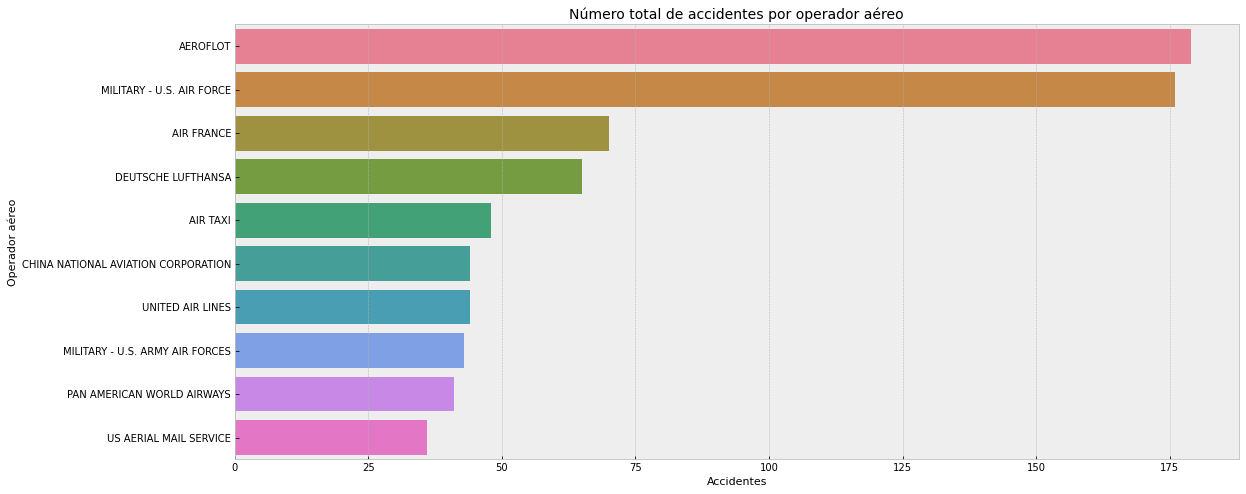

In [22]:
total_acc_by_op = df.groupby('Operator')[['Operator']].count()
total_acc_by_op = total_acc_by_op.rename(columns={"Operator": "Count"})
total_acc_by_op = total_acc_by_op.sort_values(by='Count', ascending=False).head(10)
print(total_acc_by_op, "\n")

plt.figure(figsize=(18,8))
sns.barplot(y=total_acc_by_op.index, x="Count", data=total_acc_by_op, palette="husl", orient='h')
plt.xlabel('Accidentes', fontsize=11)
plt.ylabel('Operador aéreo', fontsize=11)
plt.title('Número total de accidentes por operador aéreo', loc='Center', fontsize=14)
plt.show()

In [23]:
df[(df['Operator']=='AEROFLOT')][['Operator', 'Location', 'Aboard', 'Fatalities', 'Summary']].head(10)

,Operator,Location,Aboard,Fatalities,Summary
825,AEROFLOT,"Meshed, Iran",24.0,24.0,Crashed shortly after takeoff from Meshed airport.
1190,AEROFLOT,"Moscow, Russia",70.0,70.0,The plane overshot the runway and collided with a military aircraft killing at least 70 people.
1273,AEROFLOT,"Near Kanggye, North Korea",21.0,21.0,Shot down by a U.S. Air Force F-86 jet fighter towards the end of the Korean War. The Russian government claimed the plane was over Chinese air space.
1355,AEROFLOT,"Near Moscow, Russia",45.0,45.0,NaN
1356,AEROFLOT,"Irkutsk, Russia",17.0,17.0,Crashed during takeoff.
1386,AEROFLOT,"Near Voronezh, Russia",25.0,25.0,Crashed en route.
1494,AEROFLOT,"Copenhagen, Denmark",23.0,23.0,Crashed into the harbor after hitting the chimney of a factory.
1553,AEROFLOT,"Near Chita, Russia",64.0,64.0,The aircraft stalled after flying over a thunderstorm. The aircraft climbed in excess of its operational ceiling considering its weight.
1565,AEROFLOT,"Near Kanash, Russia",80.0,80.0,"The plane was on a flight from Peking to Moscow at FL330 when it went out of control. The aircraft experienced extreme turbulence during a climb, stalled and plunged to earth and burned. The captain described everything as it happened as he attempted to recover from the uncontrolled descent, ending the radio transmission with a farewell."
1628,AEROFLOT,"Lvov, Ukraine, USSR",40.0,40.0,Crashed during approach.


<p align="justify">Por otro lado, se procede a comprobar cuál de las aerolíneas ha causado más víctimas mortales en total a lo largo de los años de este estudio. En este caso, también es la compañía <i>Aeroflot</i>, lo cual tiene sentido, puesto que, como se vio en el gráfico anterior, es la compañía que cuenta con más accidentes aéreos causados. Por tanto, en el gráfico siguiente se muestra que dicha compañía causó el fallecimiento de 7156 personas en total. Asimismo, la segunda compañía que acumula más víctimas mortales causadas es también la estadounidense <i>U.S. Air Force</i>, con 3717 fallecimientos. </p>

                                 Fatalities
Operator                                   
AEROFLOT                         7156.0    
MILITARY - U.S. AIR FORCE        3717.0    
AIR FRANCE                       1734.0    
AMERICAN AIRLINES                1421.0    
PAN AMERICAN WORLD AIRWAYS       1302.0    
MILITARY - U.S. ARMY AIR FORCES  1070.0    
UNITED AIR LINES                 1021.0    
AVIANCA                          945.0     
TURKISH AIRLINES (THY)           891.0     
INDIAN AIRLINES                  863.0      



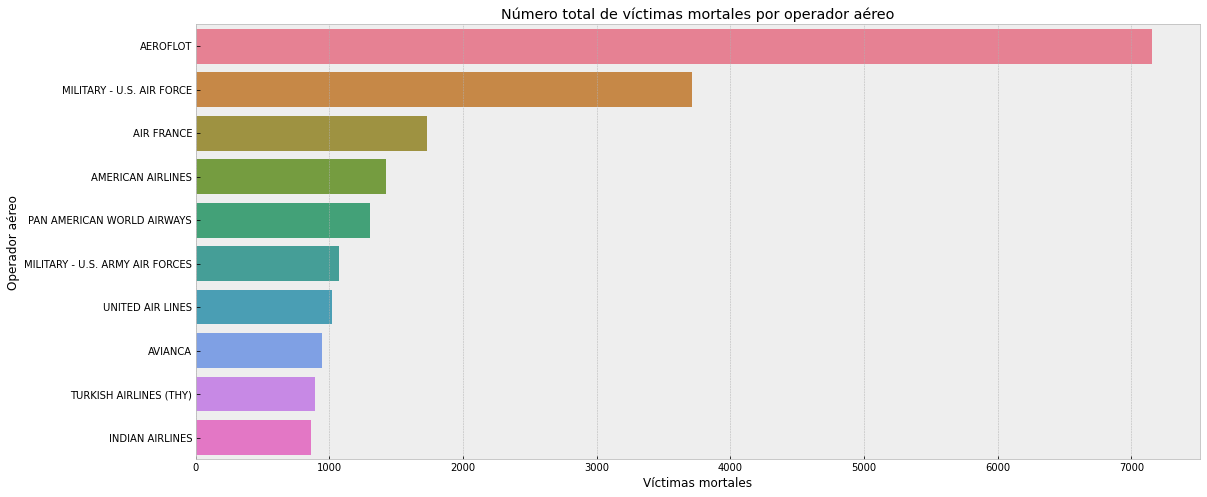

In [24]:
total_fat_by_op = df.groupby('Operator')[['Fatalities']].sum() 
total_fat_by_op = total_fat_by_op.rename(columns={"Operator": "Total Death"})
total_fat_by_op = total_fat_by_op.sort_values(by='Fatalities', ascending=False).head(10)
print(total_fat_by_op, "\n")

plt.figure(figsize=(18, 8))
sns.barplot(y=total_fat_by_op.index, x="Fatalities", data=total_fat_by_op, palette="husl")
plt.xlabel('Víctimas mortales')
plt.ylabel('Operador aéreo')
plt.title('Número total de víctimas mortales por operador aéreo')
plt.show()

<p align="justify">A continuación, se hace un desgloce del número de accidentes por año causados por la aerolínea rusa en concreto. En la representación gráfica siguiente se ve perfectamente que, en torno a la década de los 70-80, fue la época más crítica para la compañía <i>Aeroflot</i>, pues solo en el año 1973 tuvieron 15 accidentes aéreos, que dieron lugar a 767 muertos en total.</p>

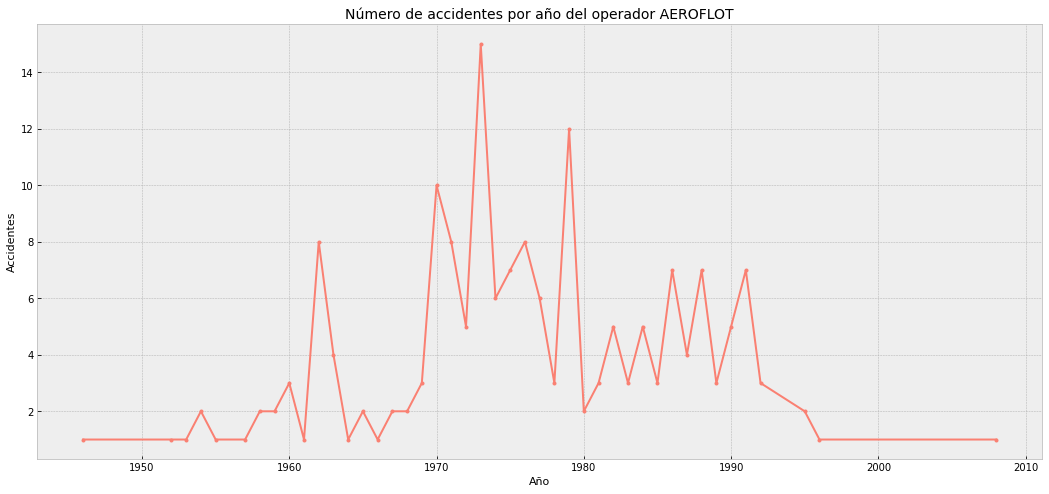

In [25]:
Aeroflot = df[df.Operator == 'AEROFLOT']

fat_by_year_aeroflot = Aeroflot.groupby(df.Time.dt.year)[['Fatalities']].sum() 
fat_by_year_aeroflot = fat_by_year_aeroflot.rename(columns={"Fatalities": "Count"})

count_by_year_aeroflot = Aeroflot.groupby(df.Time.dt.year)[['Date']].count()
count_by_year_aeroflot = count_by_year_aeroflot.rename(columns={"Date": "Count"})

plt.figure(figsize=(18,8))
plt.plot(count_by_year_aeroflot.index, 'Count', data=count_by_year_aeroflot, marker='.', color='salmon')
plt.xlabel('Año', fontsize=11)
plt.ylabel('Accidentes', fontsize=11)
plt.title('Número de accidentes por año del operador AEROFLOT', loc='Center', fontsize=14)
plt.show()

In [26]:
temp_acc = count_by_year_aeroflot.sort_values(by='Count', ascending=False).head()
temp_fat = fat_by_year_aeroflot.sort_values(by='Count', ascending=False).head()
print("Accidentes por año Aeroflot\n", temp_acc, "\nVíctimas mortales por año Aeroflot\n", temp_fat)

Accidentes por año Aeroflot
       Count
Time       
1973  15   
1979  12   
1970  10   
1976  8    
1971  8     
Víctimas mortales por año Aeroflot
       Count
Time       
1973  767.0
1972  524.0
1976  429.0
1971  405.0
1970  378.0


<p align="justify">Otro de los datos que se ha tenido en cuenta para la representación gráfica de la información ha sido el del tipo de aeronave con el que sucedió el accidente, de manera que se pueda saber si ese modelo de aeronave resultó ser un modelo fallido o el accidente estuvo más relacionado con la organizaicón y manejo de la tripulación. Como se puede observar a continuación, el modelo de aeronave con el que sucedieron más accidentes fue el "<i>Douglas DC-3</i>" con 334 accidentes a sus espaldas.</p>

                                          Count
Type                                           
Douglas DC-3                              334  
de Havilland Canada DHC-6 Twin Otter 300  81   
Douglas C-47A                             74   
Douglas C-47                              62   
Douglas DC-4                              40   
Yakovlev YAK-40                           37   
Antonov AN-26                             36   
Junkers JU-52/3m                          32   
Douglas C-47B                             29   
De Havilland DH-4                         28    



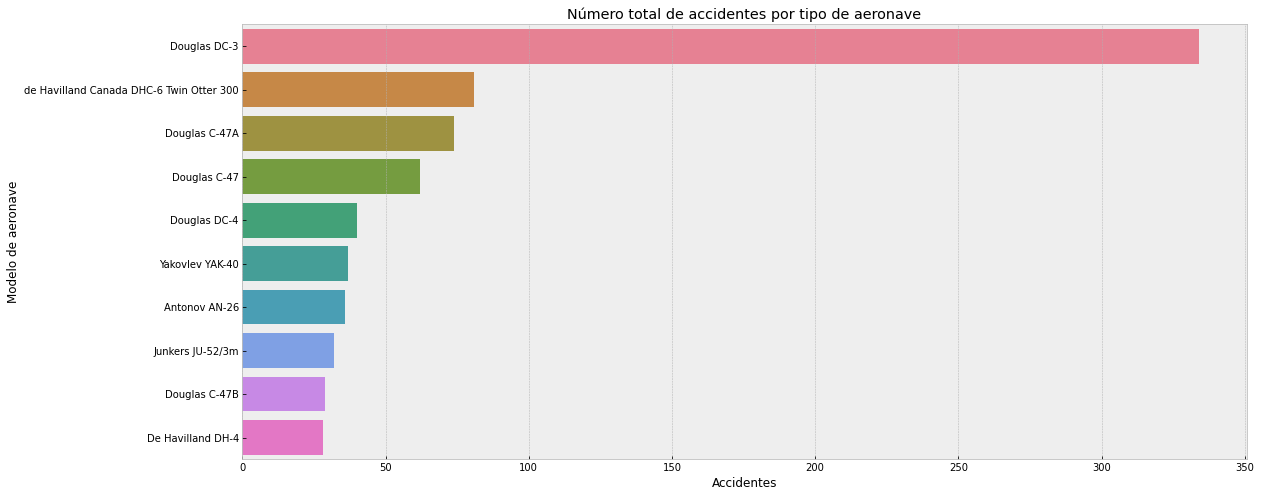

In [27]:
total_acc_by_type = df.groupby('Type')[['Type']].count()
total_acc_by_type = total_acc_by_type.rename(columns={"Type": "Count"})
total_acc_by_type = total_acc_by_type.sort_values(by='Count', ascending=False).head(10)
print(total_acc_by_type, "\n")

plt.figure(figsize=(18, 8))
sns.barplot(y=total_acc_by_type.index, x="Count", data=total_acc_by_type, palette="husl")
plt.xlabel('Accidentes')
plt.ylabel('Modelo de aeronave')
plt.title('Número total de accidentes por tipo de aeronave')
plt.show()

<p align="justify">Una vez descubierto cuál es el modelo de avión que cuenta con más accidentes a sus espaldas, se procede a mostrar los sumarios de cada uno de los accidentes para comprobar si se trata de un modelo fallido o de otra causa. Según algunas fuentes en Internet y los sumarios, se puede concluir que el modelo no presentaba ningún fallo de fábrica, sino que resultó ser una gran revolución en el transporte aéreo de pasajeros en los años 1930 y 1940, dando lugar a que muchas compañías compraran un gran número de aviones de este modelo y, en consecuencia, dando lugar a más accidentes.</p>

In [28]:
df[(df['Type']=='Douglas DC-3')][['Type','Summary']].head()

,Type,Summary
445,Douglas DC-3,"Bronislaw Hubermann, celibrated Polish violinist was sightly injured."
446,Douglas DC-3,"The plane crashed into the side of a mountain (Humpy Ridge) in level flight at 10,000 ft. under adverse weather conditions. Staticonditions encountered in the last portion of the flight which rendered the reception of radio range signals unintelligible. The continuation of the flight into mountainous country at an altitude below of higher mountains without the aid of ground visibility or radio signals to definitely identify position. A change in the weather caused by the approach of an unpredicted cold front."
495,Douglas DC-3,The aircraft flew into the ground during approach in poor visibility. The first officer was commander of the military flying school Soesterberg.
526,Douglas DC-3,One Swedish passenger was killed when the plane was attacked by German fighters. The plane was able to land safely in Amsterdam.
534,Douglas DC-3,Crashed and burned during a government test flight


<p align="justify">Por último, se estudia la cantidad de accidentes y víctimas mortales según la zona en la que ocurrieron. Si se hace hincapié en el número de accidentes, se ve claramente que la mayoría de ellos, en concreto 15, ocurrieron en Moscú, Rusia y otros 15 en Sao Paulo, Brasil.</p>

                        Count
Location                     
Moscow, Russia          15   
Sao Paulo, Brazil       15   
Rio de Janeiro, Brazil  14   
Manila, Philippines     13   
Anchorage, Alaska       13   
Bogota, Colombia        13   
New York, New York      12   
Cairo, Egypt            12   
Chicago, Illinois       11   
Tehran, Iran            9    
Near Moscow, Russia     9    
AtlantiOcean            9    
Rome, Italy             8    
Amsterdam, Netherlands  8    
Paris, France           8     



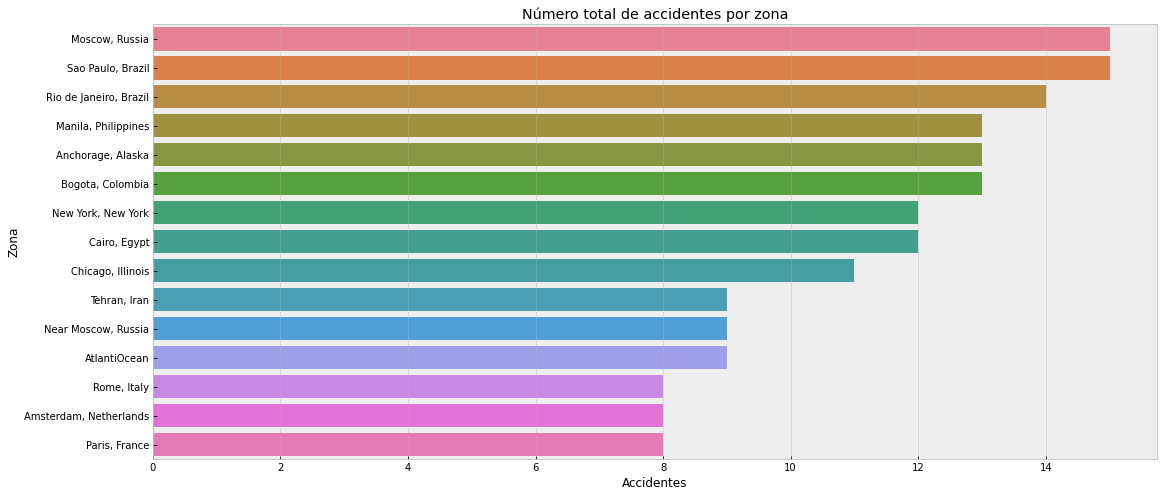

In [29]:
total_acc_by_zone = df.groupby('Location')[['Location']].count()
total_acc_by_zone = total_acc_by_zone.rename(columns={"Location": "Count"})
total_acc_by_zone = total_acc_by_zone.sort_values(by='Count', ascending=False).head(15)
print(total_acc_by_zone, "\n")

plt.figure(figsize=(18, 8))
sns.barplot(y=total_acc_by_zone.index, x="Count", data=total_acc_by_zone, palette="husl")
plt.xlabel('Accidentes')
plt.ylabel('Zona')
plt.title('Número total de accidentes por zona')
plt.show()

<p align="justify">Haciendo un despliegue de la descripción del accidente, se esclarece que no todos los accidentes tuvieron que ver con la meteorología o distribución de la zona. Por lo tanto, se podría decir que la causa de los accidentes no está directamente vinculada con la zona en la que ocurrieron.</p>

In [30]:
df[(df['Location']=='Moscow, Russia')][['Location', 'Operator', 'Summary']].head(10)

,Location,Operator,Summary
1190,"Moscow, Russia",AEROFLOT,The plane overshot the runway and collided with a military aircraft killing at least 70 people.
1684,"Moscow, Russia",AUSTRIAN AIRLINES,"Crashed on approach to Moscow, 11 nm short of the runway. Malfunctioning or misread altimeter."
2089,"Moscow, Russia",AEROFLOT,Crashed into a snowbank on the takeoff roll in poor visibility.
2216,"Moscow, Russia",AEROFLOT,Struck power lines while landing.
2335,"Moscow, Russia",AEROFLOT,Engine fire led to an emergency landing with the landing gear retracted.
2500,"Moscow, Russia",AEROFLOT,Crashed on takeoff
2640,"Moscow, Russia",BALKAN BULGARIAN AIRLINES,"Crashed, broke up and burst in flames while on second approach after descending below glide slope. Icing of tailplane."
2696,"Moscow, Russia",AEROFLOT,The aircraft crashed after the wing touched the ground while landing short of the runway.
2790,"Moscow, Russia",AEROFLOT,Crashed shortly after taking off.
2863,"Moscow, Russia",AEROFLOT,The plane rolled to the left and crashed into houses after takeoff. Failure of both artificial horizons.


In [31]:
df[(df['Location']=='Sao Paulo, Brazil')][['Location', 'Operator', 'Summary']].head(10)

,Location,Operator,Summary
469,"Sao Paulo, Brazil",CRUZEIRO DO SUL,The mail plane crashed while taking off.
664,"Sao Paulo, Brazil",PANAIR DO BRASIL,Crashed in fog.
836,"Sao Paulo, Brazil",PANAIR DO BRASIL,Crashed into the Solimoes extension of the Amazon river.
1148,"Sao Paulo, Brazil",VASP,Crashed into a house shortly after taking off from Congonhas Airport.
1203,"Sao Paulo, Brazil",VASP,Crashed while attempting to make an emergency landing after experiencing an engine failure. Failure of the port engine due to accessory drive failure. Failure of the starboard engine due to seizure as a result of deficient maintenance. Error on the part of the crew in lowering the landing gear in emergency conditions.
1269,"Sao Paulo, Brazil",PANAIR DO BRASIL,Crashed while on final approach to Sao Paulo. Error of judgement by the crew during poor visibility at night.
1327,"Sao Paulo, Brazil",VARIG,The cargo plane crashed on takeoff. Elevator lock was not removed prior to takeoff.
1406,"Sao Paulo, Brazil",CRUZEIRO DO SUD,Crashed on takeoff.
1619,"Sao Paulo, Brazil",VASP,Crashed a few minutes after taking off from Sao Paulo Airport. Cause undetermined.
1828,"Sao Paulo, Brazil",CRUZEIRO,The crippled airliner crashed into houses and burst into flames as it was coming in for an emergency landing in steady rain.


<p align="justify">Sin embargo, si se centra el estudio en el número de víctimas mortales por zona, el lugar que acumula más fallecidos es Tenerife, puesto que, como se comentó anteriormente, en el gran accidente ocurrido en el aeropuerto de Los Rodeos se contabilizó el mayor número de personas fallecidas por accidente. Si a esto se le suman las demás víctimas mortales de otros accidentes sucedidos en esta isla, da como resultado la mayor suma: 761 fallecidos en total.</p>

                                         Fatalities
Location                                           
Tenerife, Canary Islands                 761.0     
Mt. Osutaka, near Ueno Village, Japan    520.0     
Moscow, Russia                           432.0     
Near Moscow, Russia                      364.0     
Sao Paulo, Brazil                        362.0     
Near Charkhidadri, India                 349.0     
Near Ermenonville, France                346.0     
AtlantiOcean, 110 miles West of Ireland  329.0     
Taipei, Taiwan                           328.0     
Near Riyadh, Saudi Arabia                301.0      



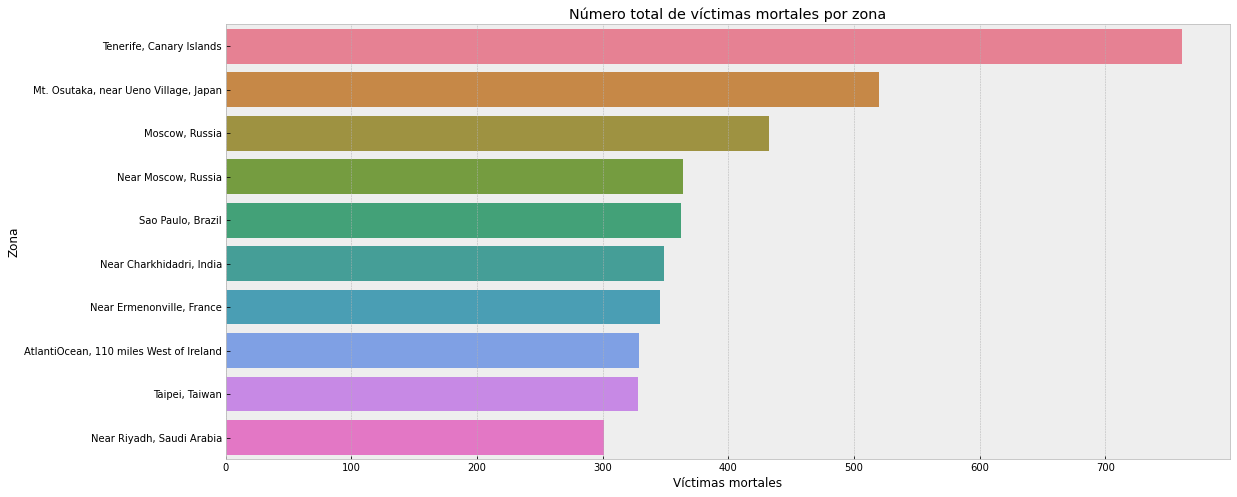

In [32]:
total_fat_by_zone = df.groupby('Location')[['Fatalities']].sum()
total_fat_by_zone = total_fat_by_zone.rename(columns={"Location": "Fatalities"})
total_fat_by_zone = total_fat_by_zone.sort_values(by='Fatalities', ascending=False).head(10)
print(total_fat_by_zone, "\n")

plt.figure(figsize=(18, 8))
sns.barplot(y=total_fat_by_zone.index, x="Fatalities", data=total_fat_by_zone, palette="husl")
plt.xlabel('Víctimas mortales')
plt.ylabel('Zona')
plt.title('Número total de víctimas mortales por zona')
plt.show()

In [33]:
df[(df['Location']=='Tenerife, Canary Islands')][['Location', 'Operator', 'Fatalities', 'Summary']].head()

,Location,Operator,Fatalities,Summary
2020,"Tenerife, Canary Islands",SPANTAX,32.0,Crashed into high terrain shortly after takeoff. Cause undetermined. Mechanical failure suspected.
2963,"Tenerife, Canary Islands",PAN AMERICAN WORLD AIRWAYS / KLM,583.0,"Both aircraft were diverted to Tenerife because of a bombing at Las Palmas Airport. After an extended delay, both planes were instructed to back track up the runway. The KLM plane reached its takeoff point while the Pan Am plane was still on the runway. The Pan Am plane continued up the runway missing the taxiway turnout. There was heavy fog on the runway. The KLM plane began its takeoff roll without permission with the Pan Am plane still on the runway. The KLM plane hit the Pan Am plane just as it was taking off. Both planes burst into flames. KLM 234 + 14 crew, Pan Am 326 + 9 crew killed. All aboard the KLM plane were killed. The Pan Am aircraft was named Clipper Victor. The KLM aircraft was named Rhine River."
3214,"Tenerife, Canary Islands",DAN AIR SERVICES,146.0,"The plane crashed into a mountain 5,500 ft. high at 300 mph during an approach to Tenerife. The pilot, while in a holding pattern, took the aircraft in an area of high ground not maintaining the correct altitude. Lack of communication between the pilot and co-pilot."


<p align="justify">Por otro lado, se puede observar que, poniendo el foco en el número de fallecidos en tierra, el lugar en el que se ha contabilizado el máximo número de víctimas mortales es Nueva York, pues el ataque al <i>World Trade Center</i>, comentado anteriormente, dio lugar a un gran número de fallecidos en tierra. Sin embargo, da como resultado un valor extremadamente alto de fallecidos en tierra, comparado con lo que se ha ido viendo a lo largo de este análisis.</p>

                              Ground
Location                            
New York City, New York       5500.0
Kinshasa, Zaire               225.0 
Arlington, Virginia.          125.0 
Santa Cruz, Bolivia           113.0 
Binh Tahi, Da Nang, Vietnam   107.0 
Ankara, Turkey                87.0  
Lviv, Ukraine                 85.0  
Kano, Nigeria                 75.0  
Kaiserslautern, West Germany  70.0  
Maracaibo, Zulia, Venezuela   70.0   



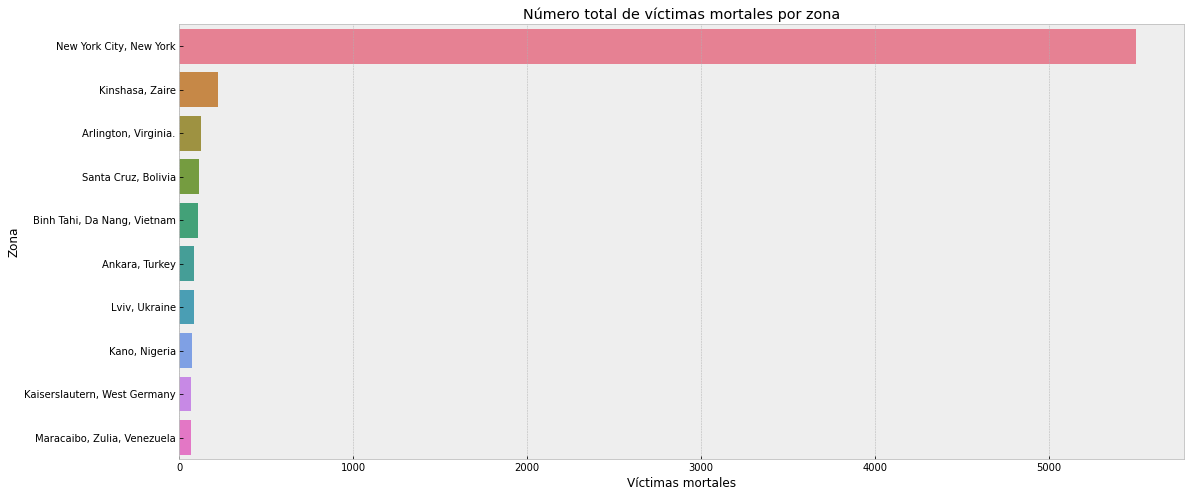

In [34]:
total_gr_by_zone = df.groupby('Location')[['Ground']].sum()
total_gr_by_zone = total_gr_by_zone.rename(columns={"Location": "Ground"})
total_gr_by_zone = total_gr_by_zone.sort_values(by='Ground', ascending=False).head(10)
print(total_gr_by_zone, "\n")

plt.figure(figsize=(18, 8))
sns.barplot(y=total_gr_by_zone.index, x="Ground", data=total_gr_by_zone, palette="husl")
plt.xlabel('Víctimas mortales')
plt.ylabel('Zona')
plt.title('Número total de víctimas mortales por zona')
plt.show()

Esto se debe a que el atentado terrorista fue perpetrado por dos aviones, causando un total de 2750 fallecidos en tierra en total. Como no se puede saber cuántos causó cada avión en concreto, se ha puesto el mismo valor en los dos registros. Es por esto que, al hacer la suma, sale un valor tan elevado, en concreto, el doble de los fallecidos en tierra. Igualmente, aunque se dividiera ese dato a la mitad, seguiría siendo el accidente que más fallecidos en tierra ha causado con diferencia a lo largo de los años de estudio.

In [35]:
df[(df['Location']=='New York City, New York')][['Operator', 'Fatalities', 'Ground', 'Summary']].head()

,Operator,Fatalities,Ground,Summary
754,EASTERN AIR LINES,1.0,0.0,"The pilot, in the belief that he was encountering engine trouble, attempted a landing despite a landing approach which was too high and too fast. Initial contact with the runway was made at a point which provided insufficient room for a landing roll and at an airspeed considerable in excess of normal. The pilot was unable to bring the aircraft to a stop in time to avoid overshooting the runway. The decision of the pilot in attempting a landing from an approach which was too high and too fast."
1289,EASTERN AIR LINES,2.0,0.0,The aircraft crashed a few seconds after becoming airborne. The captain's loss of visual reference and orientation when he encountered drifting fog shortly after becoming airborne on take-off and the resultant inadvertent assumption of a descending flight path.
2325,NEW YORK AIRWAYS,3.0,0.0,The plane flew into wake turbulence and crashed. The pilot was 12 minutes behind schedule and made an intersection takeoff. The tower warned him of wake turbulence from a recently departing jet.
4803,AMERICAN AIRLINES,92.0,2750.0,"The aircraft was hijacked shortly after it left Logan International Airport in Boston. The hijackers took control of the aircraft and deliberately crashed it into the north tower of the World Trade Center between the 94th and 99th floors at approximately 450 mph. After 102 minutes, the building collapsed. It was one of four planes that were hijacked the same day."
4804,UNITED AIR LINES,65.0,2750.0,"The aircraft was hijacked shortly after it left Logan International Airport in Boston. The hijackers took control of the aircraft and deliberately crashed it into the south tower of the World Trade Center between the 78th and 84th floors at approximately 550 mph. After 56 minutes, the building collapsed. It was one of four planes that were hijacked the same day."


#### Análisis de valores perdidos

<p align="justify">Una vez comprendida la estructura del <i>dataset</i> y vistos algunos de sus valores máximos y sus causas y después de haber hecho una representación gráfica de la información que aporta, se procede al estudio de la cantidad de valores nulos encontrados en el conjunto de datos. El primer paso es el de saber cuántas instancias en total hay en el <i>dataset</i>, es decir, cuántos accidentes hay registrados. En este caso, se cuenta con 5268 accidentes aéreos, contabilizados en 101 años.</p>

In [36]:
len(df) 

5268

<p align="justify">Lo siguiente que se debe hacer es contar la cantidad de valores nulos que se encuentran en el conjunto de datos por cada una de las columnas.</p>

In [37]:
df.isnull().sum()

Date            0   
Time            0   
Location        20  
Operator        18  
Flight #        4199
Route           1706
Type            27  
Registration    335 
cn/In           1228
Aboard          22  
Fatalities      12  
Ground          22  
Summary         390 
dtype: int64

<p align="justify">Como este proyecto se centra en el número de accidentes, junto con la cantidad de víctimas mortales y fallecidos en tierra, se hará hincapié en el manejo de los valores nulos encontrados en estas tres columnas concretas. Al poseer 5268 registros de accidentes y después de haber comprobado que solo faltan datos en 22, 12 y 22 registros relativos a los pasajeros a bordo, las víctimas mortales y los fallecidos en tierra, respectivamente, se ha decidido eliminar esas filas, puesto que se acaba teniendo como resultado una gran cantidad de registros para ser evaluados, en concreto 5236. De esta manera, se consigue que no haya valores nulos en ninguna de las columnas objetivo que se han elegido.</p>

In [38]:
df = df.dropna(axis=0, subset=['Fatalities', 'Ground', 'Aboard'])

In [39]:
len(df) 

5236

In [40]:
df.isnull().sum()

Date            0   
Time            0   
Location        19  
Operator        18  
Flight #        4169
Route           1686
Type            25  
Registration    327 
cn/In           1209
Aboard          0   
Fatalities      0   
Ground          0   
Summary         382 
dtype: int64

#### Correlación de variables

<p align="justify">El siguiente paso que se debe llevar a cabo es el de comprobar si las variables están correlacionadas entre sí, de manera que se pueda simplificar el conjunto de datos para hacer más sencilla su evaluación posterior. En este caso, encontramos que ninguna de las variables está correlacionada entre sí, puesto que tiene valores lejanos a uno.</p>

In [41]:
df.corr()

,Aboard,Fatalities,Ground
Aboard,1.000000,0.757101,0.023241
Fatalities,0.757101,1.000000,0.035149
Ground,0.023241,0.035149,1.000000


<p align="justify">En el mapa de calor que se muestra a continuación, es más fácil observar que ninguno de los valores está fuertemente correlacionado entre sí, ya que se ha puesto como valor mínimo de correlación 0.80. Ninguno de los valores supera ese mínimo. Por tanto, se puede decir que las variables no están correlacioandas.</p>

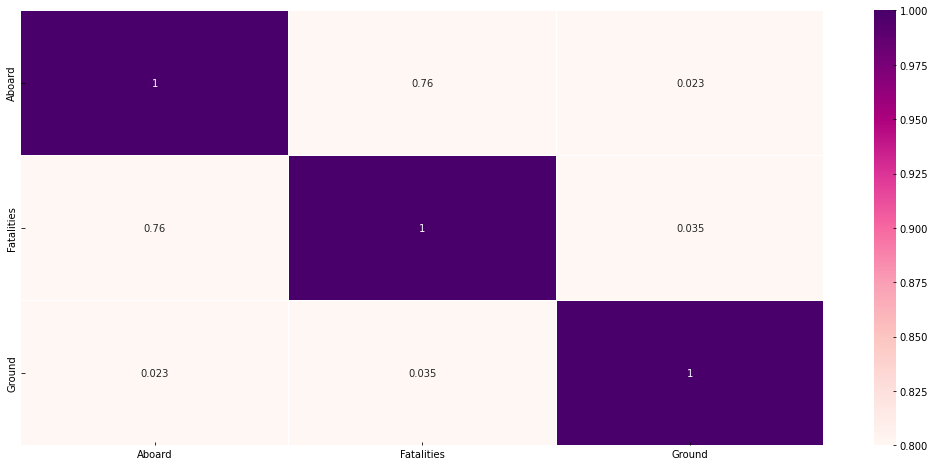

In [42]:
#Se muestra en un mapa de calor las correlaciones entre las características. En este caso, las variables no están correlacionadas entre sí.
plt.figure(figsize=(18,8))
sns.heatmap(df.corr(), vmin=0.80, vmax=1, annot=True, cmap='RdPu', linewidths=.5)
plt.show()

### Modelado ARIMA

<p align="justify"> Para proceder a la creación de los modelos predictivos, se requiere realizar una serie de pasos previamente. En primer lugar, comprobar que la serie temporal es estacionaria y, de no ser así, averiguar cómo hacerla estacionaria. Por otro lado, se deben calcular los parámetros que se van a pasar al modelo con los que se consigan mejores resultados de error.</p>

<p align="justify"> En este caso, se va a utilizar el modelo ARIMA (<i>AutoRegressive Integrated Moving Average</i>), que es una combinación del modelo autorregresivo integrado con el modelo de la media móvil. Este tipo de modelos necesita ser proveído de los siguientes parámetros:</p>

<ul type="1" align="justify">
  <li><i>p</i>: Número de saltos atrás o retrasos que están incluídos en el modelo. También llamado <i>lag order</i>.</li>
  <li><i>d</i>: Número de veces que se debe diferenciar la serie temporal. También conocido como <i>degree of differencing</i>.</li>
  <li><i>q</i>: Tamaño de la ventana de la media móvil. También llamado <i>order of moving average</i>.</li>
</ul>

#### Cálculo de Estacionariedad

<p align="justify">Como se comentó con anterioridad, se debe comprobar si la serie temporal es estacionaria, es decir, no tiene tendencia ni estacionalidad. Para eso, se hará uso del test "<i>Augmented Dicky Fuller (ADF)</i>". Este test se encarga de comprobar si existe o no una raíz unitaria en la serie temporal. Si se consigue rechazar la hipótesis nula, es decir, se consigue comprobar que no hay una raíz unitaria en la serie temporal, entonces se trata de una serie temporal estacionaria.</p>

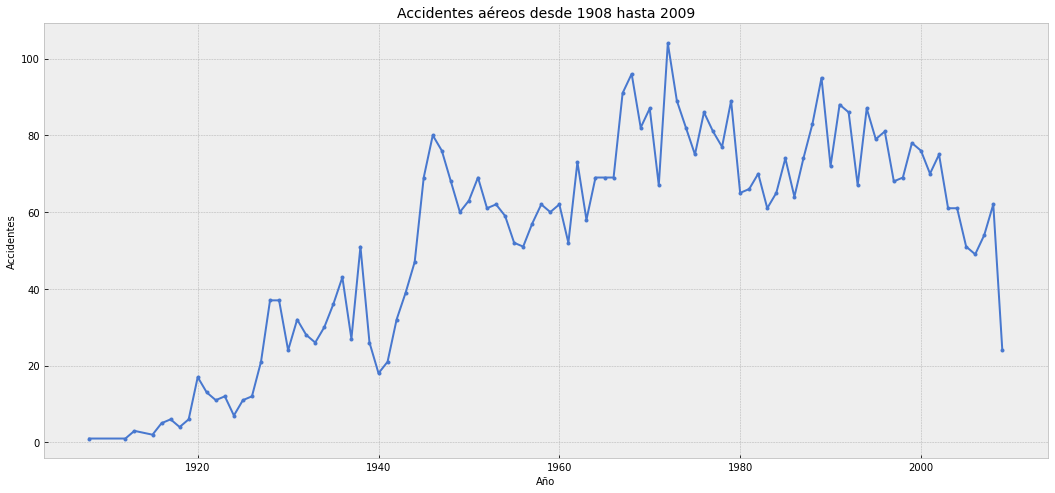

In [43]:
plt.figure(figsize=(18,8))
plt.plot(year_count.index, 'Count', data=year_count, marker = ".")
plt.xlabel('Año', fontsize=10)
plt.ylabel('Accidentes', fontsize=10)
plt.title('Accidentes aéreos desde 1908 hasta 2009', loc='Center', fontsize=14)
plt.show()

<p align="justify">Para poder llevar a cabo el test ADF, se ha implementado la función que se muestra a continuación: en ella se calculan tanto la <i>rolling mean</i>, que sirve para encontrar tendencias que de otras maneras sería complicado detectar, como la <i>rolling std</i>, que muestra la desviación estándar de la ventana móvil. Además, se calcula también el test ADF y se muestran por pantalla los resultados: <i>Test Statistic, p-value, Critical Values</i>.</p>

In [44]:
def test_stationarity(timeseries):
    #Determing rolling statistics
    rolmean = timeseries.rolling(12).mean()
    rolstd = timeseries.rolling(12).std()

    #Plot rolling statistics:
    plt.figure(figsize=(18,8))
    orig = plt.plot(timeseries,label='Original', marker='.')
    mean = plt.plot(rolmean, color='mediumorchid', label='Rolling Mean', marker='.')
    std = plt.plot(rolstd, color='darkturquoise', label = 'Rolling Std', marker='.')
    plt.legend(loc='best')
    plt.title('Accidentes Aéreos')
    plt.show(block=False)
    
    #Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)

<p align="justify">Con el fin de comprobar si esta serie temporal es estacionaria o no, se debe comprobar si el <i>p-value</i> es menor que 0.05 y el valor del <i>Test Statistic</i> es menor que los <i>Critical Values</i>. Si resulta que el <i>p-value</i> es mayor que 0.05 y el <i>Test Statistic</i> es mayor que los <i>Critical Values</i>, se dice que se ha fallado en rechazar la hipótesis nula y, por tanto, se trata de una serie temporal no estacionaria.</p>

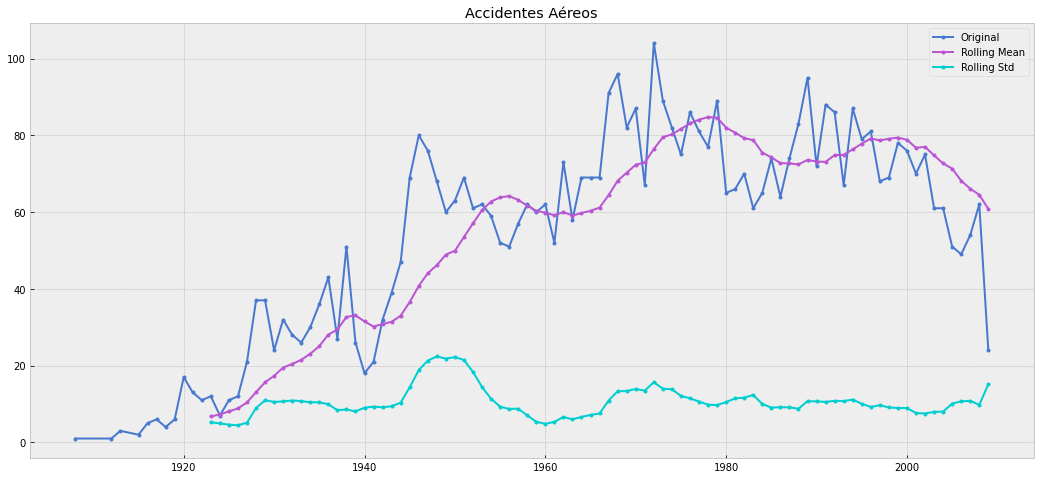

Results of Dickey-Fuller Test:
Test Statistic                -2.055727 
p-value                        0.262685 
#Lags Used                     1.000000 
Number of Observations Used    96.000000
Critical Value (1%)           -3.500379 
Critical Value (5%)           -2.892152 
Critical Value (10%)          -2.583100 
dtype: float64


In [45]:
test_stationarity(year_count)

<p align="justify">Como se ve en las dos líneas de código a continuación, el <i>p-valor</i> es mayor que 0.05 y el <i>Test Statistic</i> es mayor que los <i>Critical Values</i>, por tanto, se falla en rechazar la hipótesis nula y se puede decir entonces que la serie temporal no es estacionaria.</p>

In [46]:
0.262685 < 0.05

False

In [47]:
-2.055727 > -2.583100 > -2.892152 > -3.500379

True

<p align="justify">Otra de las formas con las que se puede comprobar si una serie temporal es estacionaria o no es haciendo una descomposición de sus valores. En dicha descomposición se mostrará la serie original, junto con su tendencia y su estacionalidad, así como los residuos. En el gráfico siguiente, se observa que esta serie temporal presenta una pequeña tendencia ascendente. Hay casos en los que es bastante difícil comprobar a ojo si la serie temporal tiene tendencia o estacionalidad y es por eso que es necesario el uso de tests que lo demuestren.</p>

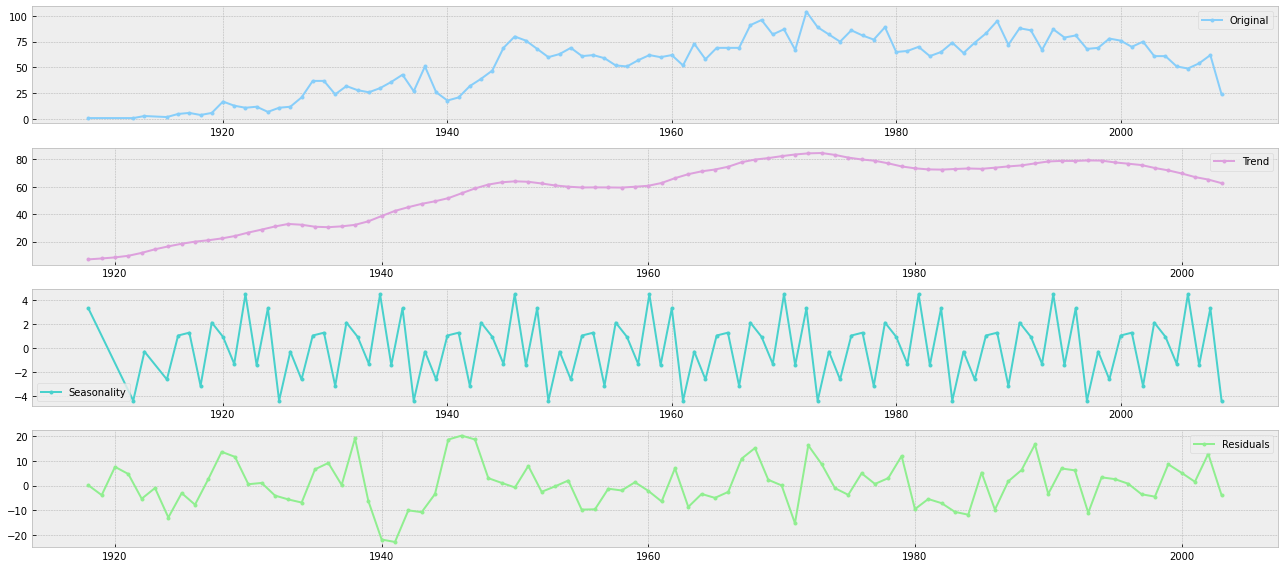

In [48]:
decomposition = seasonal_decompose(year_count, period=12)
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid
plt.rcParams['figure.figsize'] = (18, 8) 
plt.subplot(411)
plt.plot(year_count, label='Original', color="lightskyblue", marker='.')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend', color="plum", marker='.')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality', color="mediumturquoise", marker='.')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals', color="lightgreen", marker='.')
plt.legend(loc='best')
plt.tight_layout()

#### Diferenciación para hacer la serie temporal estacionaria

<p align="justify">Para poder convertir una serie temporal no estacionaria a estacionaria se debe realizar la diferenciación o integración de los datos, es decir, restar a los datos de este instante los datos del instante anterior. Se necesita saber cuántas veces es necesario hacer la diferencia para conseguir que la serie temporal sea estacionaria. Para ello, se hace uso de la función <i>.diff()</i>, que es equivalente a restar el dato del instante actual menos el dato de su izquierda, es decir, el dato del instante anterior.</p>

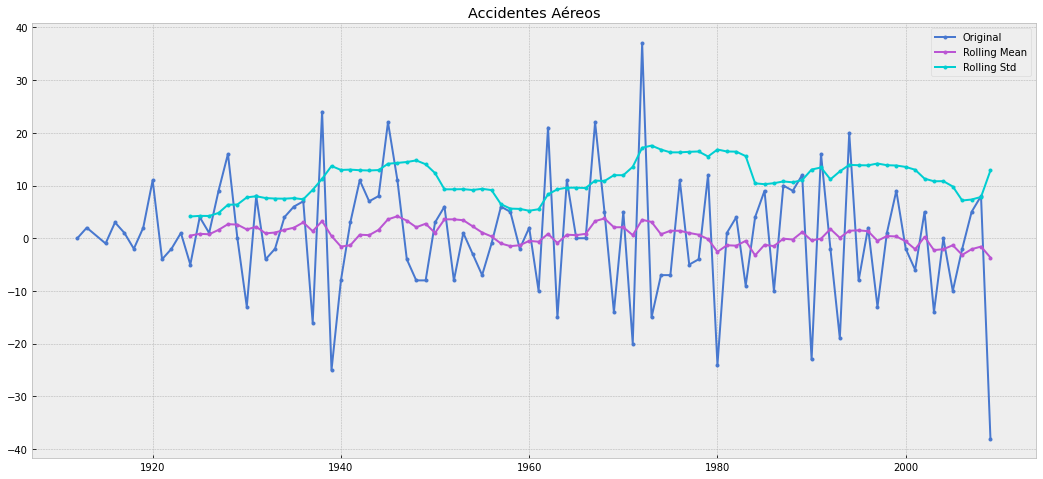

Results of Dickey-Fuller Test:
Test Statistic                -1.361342e+01
p-value                        1.854509e-25
#Lags Used                     0.000000e+00
Number of Observations Used    9.600000e+01
Critical Value (1%)           -3.500379e+00
Critical Value (5%)           -2.892152e+00
Critical Value (10%)          -2.583100e+00
dtype: float64


In [49]:
year_count_first_diff = year_count.diff().dropna() #( equivalente a hacer year_count- year_count.shift())
test_stationarity(year_count_first_diff)

Después de haber realizado una primera diferencia, se comprueba que tanto el  <i>p-value</i> es menor que 0.05, como que el valor del <i>Test Statistic</i> es menor que los <i>Critical Values</i> y, por tanto, se ha conseguido hacer la serie temporal estacionaria con una sola diferenciación.

In [50]:
1.854509e-25 < 0.05

True

In [51]:
-1.361342e+01 < -3.500379e+00 < -2.892152e+00 < -2.583100e+00

True

<p align="justify">Una vez hecho esto, se vuelve a descomponer la serie temporal después de haber realizado la diferencia y se puede ver cómo han cambiado los distintos valores con respecto a los anteriores.</p>

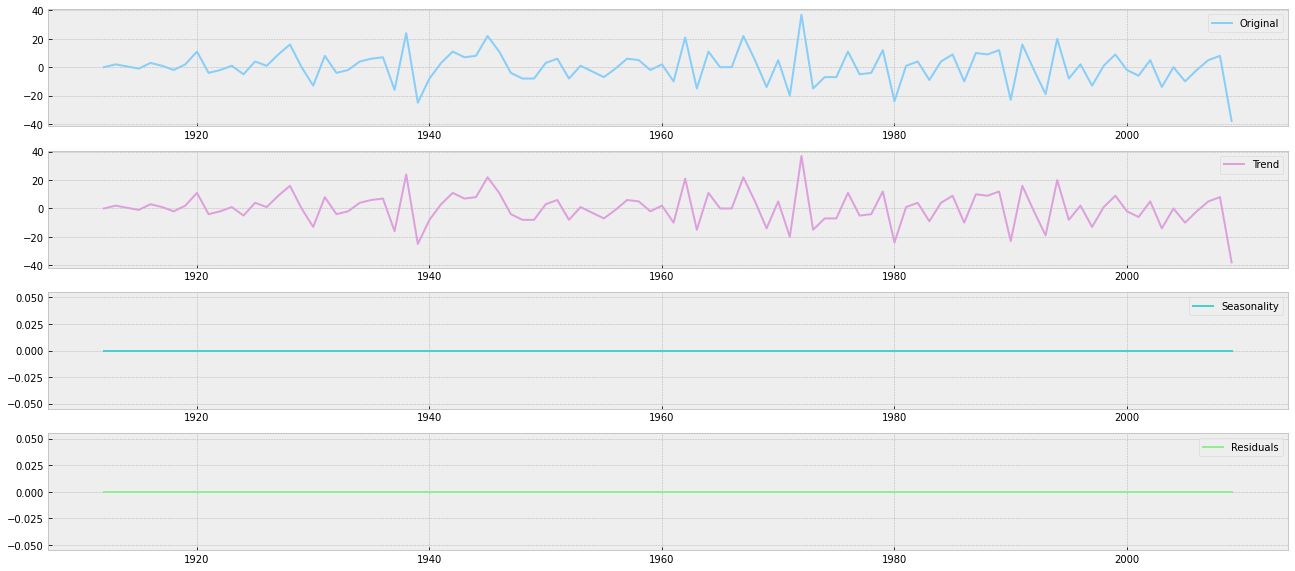

In [52]:
decomposition = seasonal_decompose(year_count_first_diff, period=1)
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid
plt.rcParams['figure.figsize'] = (18, 8)
plt.subplot(411)
plt.plot(year_count_first_diff, label='Original', color="lightskyblue")
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend', color="plum")
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality', color="mediumturquoise")
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals', color="lightgreen")
plt.legend(loc='best')
plt.tight_layout()

<p align="justify">Gracias a este paso, ya se conoce el valor del parámetro <i>d</i> del modelo ARIMA, que en este caso es igual a 1.</p>

#### Función de Autocorrelación

<p align="justify">Ahora, solo falta conocer los valores de los parámetros <i>p</i> y <i>q</i> del modelo ARIMA. Para ello, se hará uso de dos funciones:</p>

<ul type="1" align="justify">
  <li>Función de Autocorrelación (ACF): Es la medida de la correlación entre una serie temporal con una versión anterior de la misma.</li>
  <li>Función de Autocorrelación Parcial (PACF): Es la medida de la correlación entre una serie temporal con una versión anterior de la misma, pero habiendo eliminado las variaciones ya mostradas por las comparaciones intervinientes.</li>
</ul>

<p align="justify">Por tanto, los parámetros serán calculados de la siguiente manera:</p>

<ul type="1" align="justify">
  <li><i>p</i>: El valor del retraso o salto atrás con el que la gráfica del PACF cruza el intervalo de significancia por primera vez.</li>
  <li><i>q</i>: El valor del retraso o salto atrás con el que la gráfica del ACF cruza el intervalo de significancia por primera vez.</li>
</ul>

Las funciones de autocorrelación de la serie temporal sin integrar, muestran y comprueban, una vez más, que la serie temporal necesita ser integrada para poder ser estacionaria, pues en la gráfica se ve esa tendencia decremental de los valores.

<Figure size 1296x576 with 0 Axes>

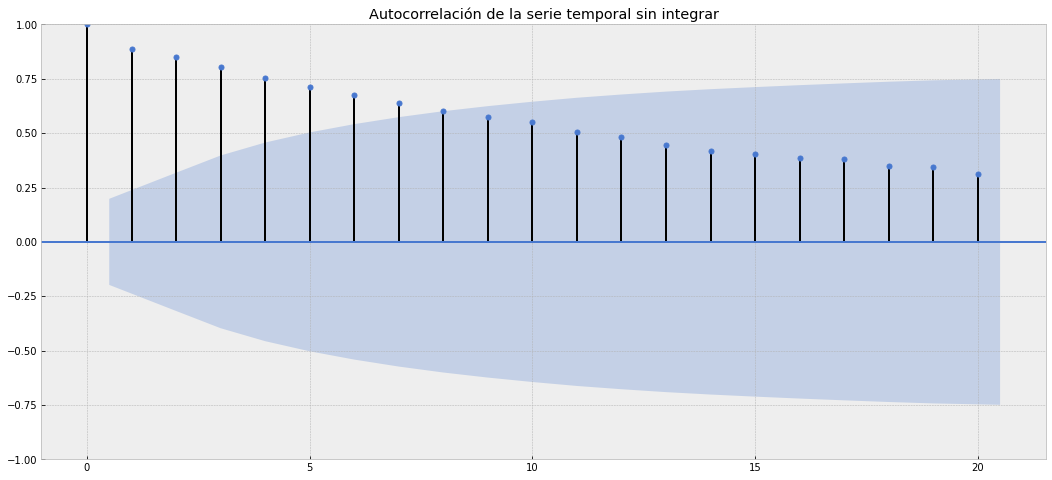

In [53]:
plt.figure(figsize=(18,8))
plot_acf(year_count, title='Autocorrelación de la serie temporal sin integrar');

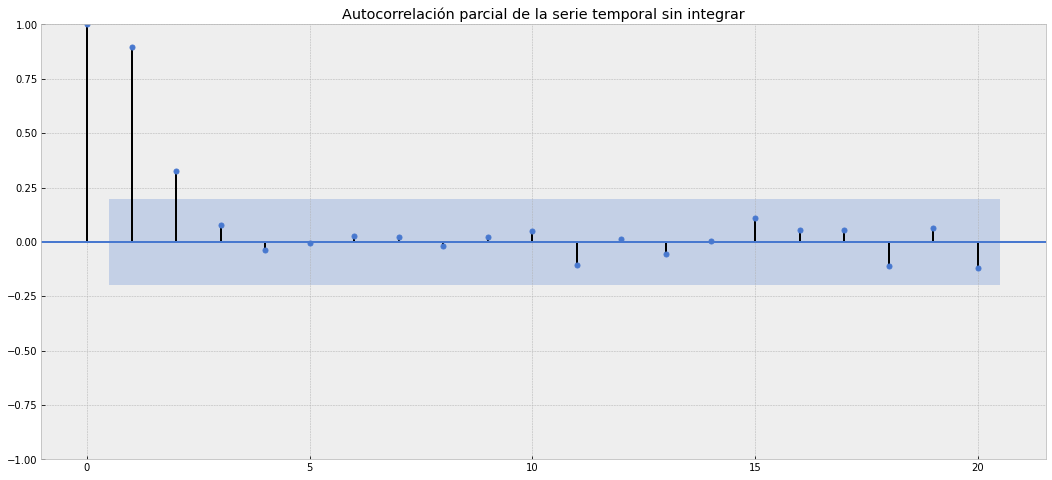

In [54]:
plot_pacf(year_count, title='Autocorrelación parcial de la serie temporal sin integrar'); 

<p align="justify"> Por tanto, una vez hecha la función de autocorrelación a la serie temporal integrada, se puede ver como resultado que el primer valor que supera el intervalo de significancia es el 1. Por tanto, el modelo ARIMA será provisto de <i>q</i> = 1.</p>

<Figure size 1296x576 with 0 Axes>

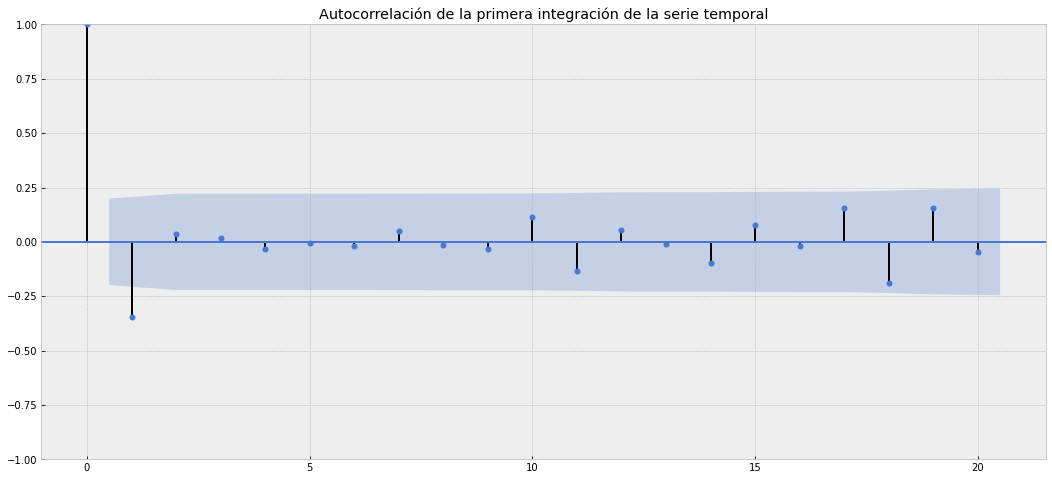

In [55]:
plt.figure(figsize=(18,8))
plot_acf(year_count_first_diff, title='Autocorrelación de la primera integración de la serie temporal');

<p align="justify">Por otro lado, al igual que sucedía en la imagen anterior, en esta se observa que el valor 1 también es el que sobrepasa el intervalo de significancia. Es por esto que, para el modelo ARIMA que se va a construir se va a establecer que <i>p</i>= 1.</p

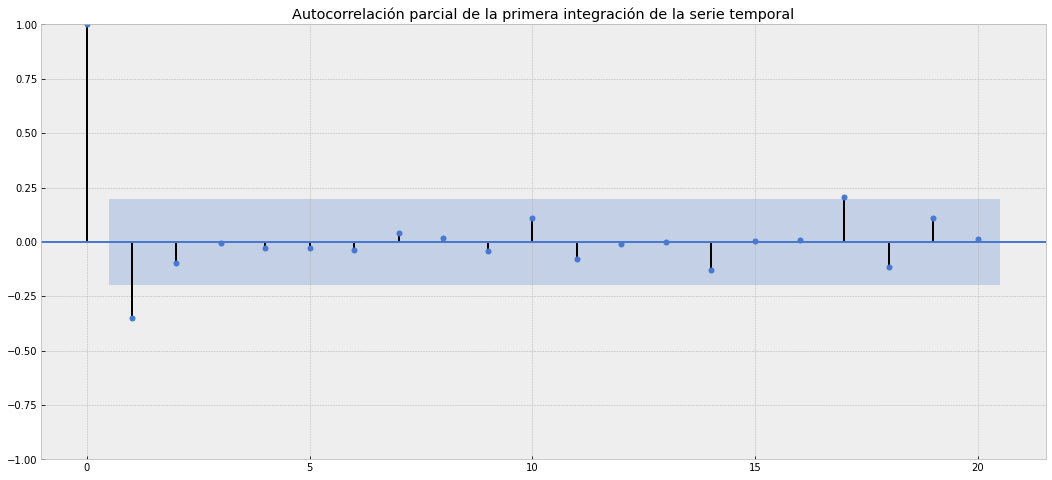

In [56]:
plot_pacf(year_count_first_diff, title='Autocorrelación parcial de la primera integración de la serie temporal');

#### Modelo ARIMA

<p align="justify">Una vez obtenidos los valores de los parámetros <i>p</i>, <i>d</i> y <i>q</i>, se puede proceder a la creación del modelo ARIMA. Para este fin, se ha decidido separar una parte de la serie temporal original(azul) destinada al testeo del modelo (rosa).</p>

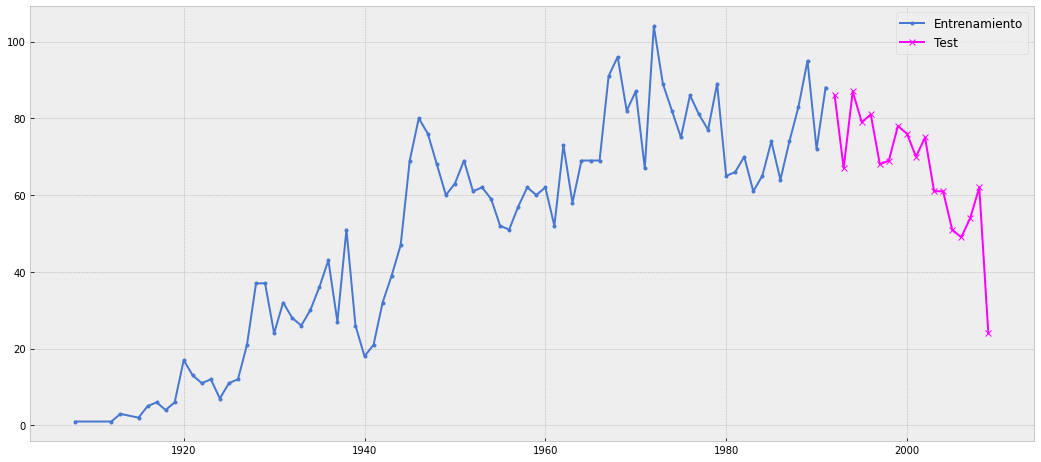

In [57]:
test = year_count.iloc[80:]
plt.figure(figsize=(18,8))
plt.plot(year_count.iloc[:80], marker='.', label='Entrenamiento')
plt.plot(test, marker='x', color='magenta', label='Test')
plt.legend(fontsize=12)

<p align="justify">A continuación, se procede a crear el modelo y entrenarlo. Una vez hecho esto, se muestra en la gráfica lla serie temporal original(azul), los valores de test (rosa) y las predicciones (verde).</p>

                               SARIMAX Results                                
Dep. Variable:                  Count   No. Observations:                   98
Model:                 ARIMA(1, 1, 1)   Log Likelihood                -366.398
Date:                Thu, 15 Sep 2022   AIC                            738.795
Time:                        11:50:30   BIC                            746.520
Sample:                             0   HQIC                           741.919
                                 - 98                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1495      0.314     -0.477      0.634      -0.764       0.465
ma.L1         -0.2748      0.288     -0.955      0.340      -0.839       0.289
sigma2       111.5925     14.465      7.715      0.0

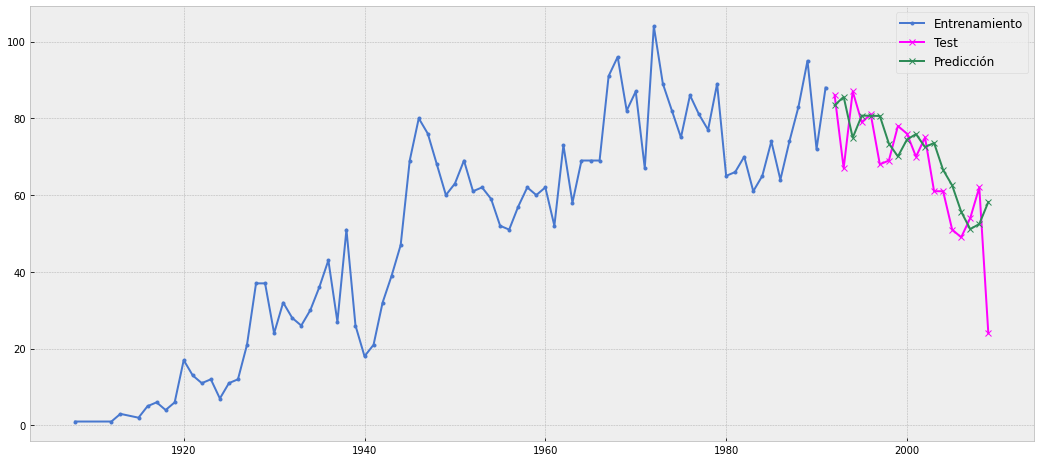

In [58]:
model = ARIMA(year_count, order=(1, 1, 1))  
results_AR_acc = model.fit()
print(results_AR_acc.summary())
plt.figure(figsize=(18,8))
plt.plot(year_count.iloc[:80], marker='.', label='Entrenamiento')
plt.plot(test, marker='x', color='magenta', label='Test')
plt.plot(results_AR_acc.fittedvalues.iloc[80:], marker='x', color='seagreen', label='Predicción')
plt.legend(fontsize=12)

<p align="justify">Luego, se calcula la raíz del error cuadrático medio (rmse) que, cuanto más baja sea, mejor es el modelo. En este caso, ha dado como resultado un rsme igual a 11.59 que resulta ser un valor bastante bajo.</p>

In [59]:
rmse_arima = sqrt(mean_squared_error(test, results_AR_acc.fittedvalues.iloc[80:]))
rmse_arima

11.591581856596488

<p align="justify">Finalmente, se muestran los residuos y el cálculo de la densidad, de manera que se compruebe que no haya ningún patrón existente, es decir, que haya una media o varianza constante. En este caso, se puede ver en la gráfica que se muestra a continuación que no existe ningún valor constante. Además, presenta una función de densidad normal y una media cercana a cero. Lo cual quiere decir que el modelo es bastante bueno.</p>

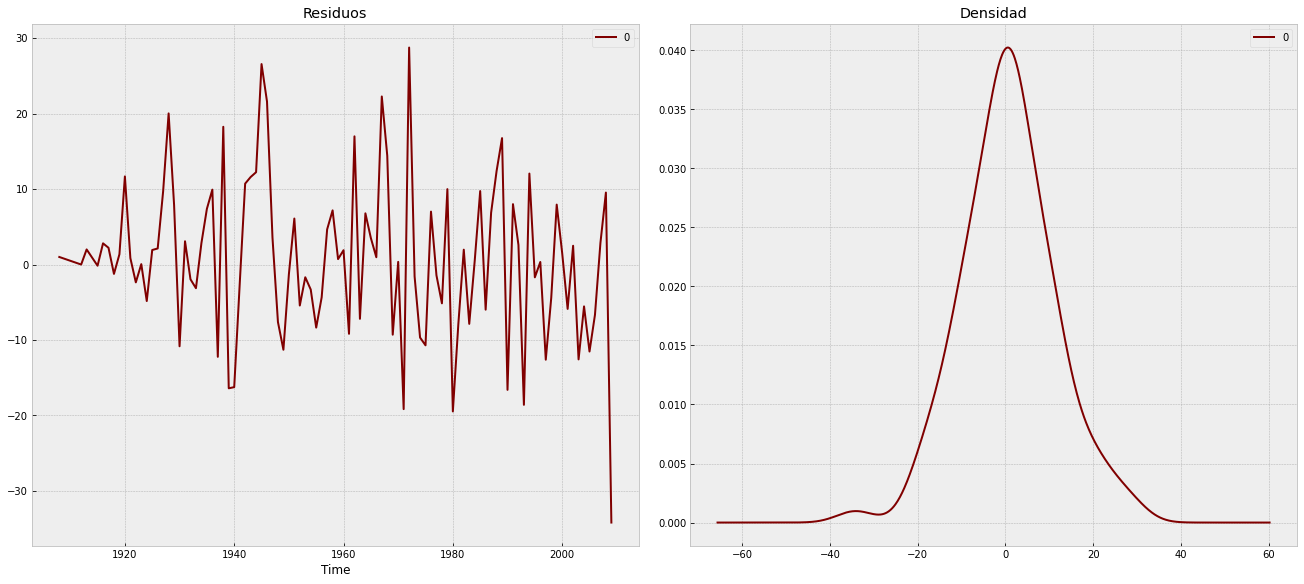

               0
count  98.000000
mean   0.594236 
std    10.547288
min   -34.183511
25%   -5.796208 
50%    0.785855 
75%    7.135403 
max    28.746280


In [60]:
#Se calcula para comprobar que no haya ningún patrón, es decir, media o varianza constante)
residuals = pd.DataFrame(results_AR_acc.resid)

fig, ax = plt.subplots(1, 2, figsize=(18, 8), constrained_layout=True)
residuals.plot(title='Residuos', ax=ax[0], color='maroon')
residuals.plot(kind='kde', title='Densidad', ax=ax[1], color='maroon')
ax[1].set_ylabel('')
plt.show()
print(residuals.describe())

<p align="justify">Finalmente, se muestra la función de autocorrelación parcial de los residuos y también se puede ver que no hay valores que se salgan del área de significancia.</p>

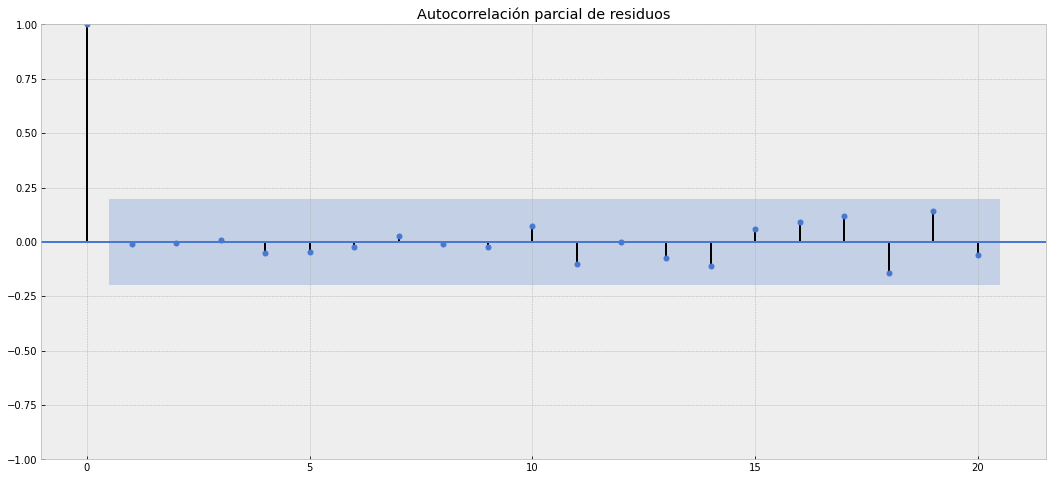

In [63]:
plot_pacf(residuals, title="Autocorrelación parcial de residuos");

#### Auto ARIMA

<p align="justify"> Otra de las maneras con las que se pueden calcular los parámetros con los que se va a alimentar el modelo ARIMA, es haciendo uso de la función <i>auto_arima</i>. Esta función se encarga de calcular los valores óptimos de <i>p</i>, <i>d</i> y <i>q</i> para una serie temporal concreta. En este caso, nos devuelve los siguientes valores:</p>
<ul type="1" align="justify">
  <li><i>p</i> = 0</li>
  <li><i>d</i> = 1</li>
  <li><i>q</i> = 1</li>
</ul>

In [64]:
autoarima = auto_arima(year_count)
autoarima

ARIMA(order=(0, 1, 1), scoring_args={}, suppress_warnings=True,
      with_intercept=False)

<p align="justify">Una vez calculados, se crea el modelo y se entrena. Luego, se muestran los datos originales (azul) y los datos que se deben predecir(rosa), frente a los datos predichos por el modelo (naranja).</p>

                               SARIMAX Results                                
Dep. Variable:                  Count   No. Observations:                   98
Model:                 ARIMA(0, 1, 1)   Log Likelihood                -366.545
Date:                Thu, 15 Sep 2022   AIC                            737.090
Time:                        11:54:03   BIC                            742.240
Sample:                             0   HQIC                           739.173
                                 - 98                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.4018      0.078     -5.138      0.000      -0.555      -0.248
sigma2       111.9375     13.603      8.229      0.000      85.276     138.599
Ljung-Box (L1) (Q):                   0.09   Jarque-

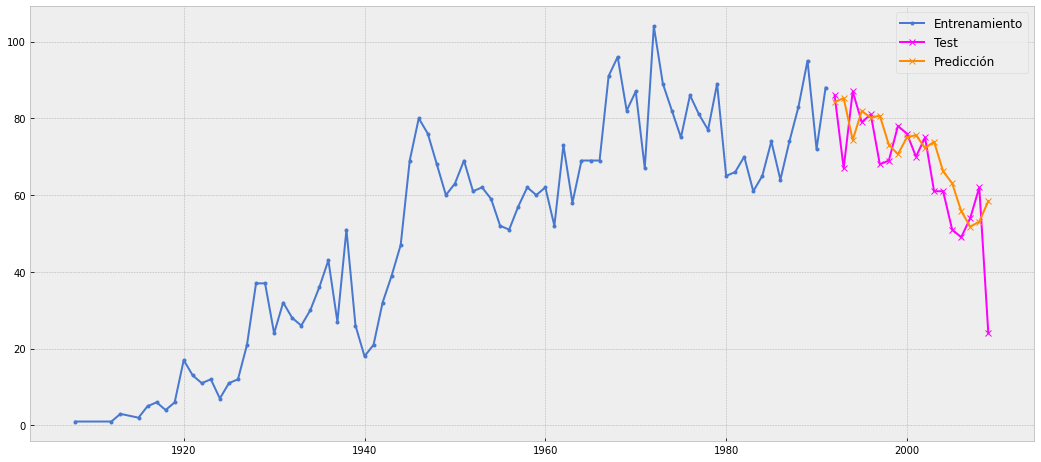

In [65]:
model = ARIMA(year_count, order=(0, 1, 1))
results_autoARIMA_acc = model.fit()
print(results_autoARIMA_acc.summary())
plt.figure(figsize=(18,8))
plt.plot(year_count.iloc[:80], marker='.', label='Entrenamiento')
plt.plot(test, marker='x', color='magenta', label='Test')
plt.plot(results_autoARIMA_acc.fittedvalues.iloc[80:], marker='x', color='darkorange', label='Predicción')
plt.legend(fontsize=12)

<p align="justify">Después, basta con calcular el rmse del modelo, dando como resultado un valor de 11.63, que al igual que el modelo anterior, también es bastante bajo. </p>

In [66]:
rmse_autoarima = sqrt(mean_squared_error(test, results_autoARIMA_acc.fittedvalues.iloc[80:]))
rmse_autoarima

11.626889657245831

<p align="justify">Finalmente, se muestran de nuevo los residuos y el cálculo de la densidad, para comprobar que no haya ningún patrón existente. En la gráfica siguiente se puede ver que no existe ningún valor constante. Con autoarima, también se ve una gráfica de densidad normal centrada a cero y una media cercana a cero que indica que el modelo es bueno.</p>

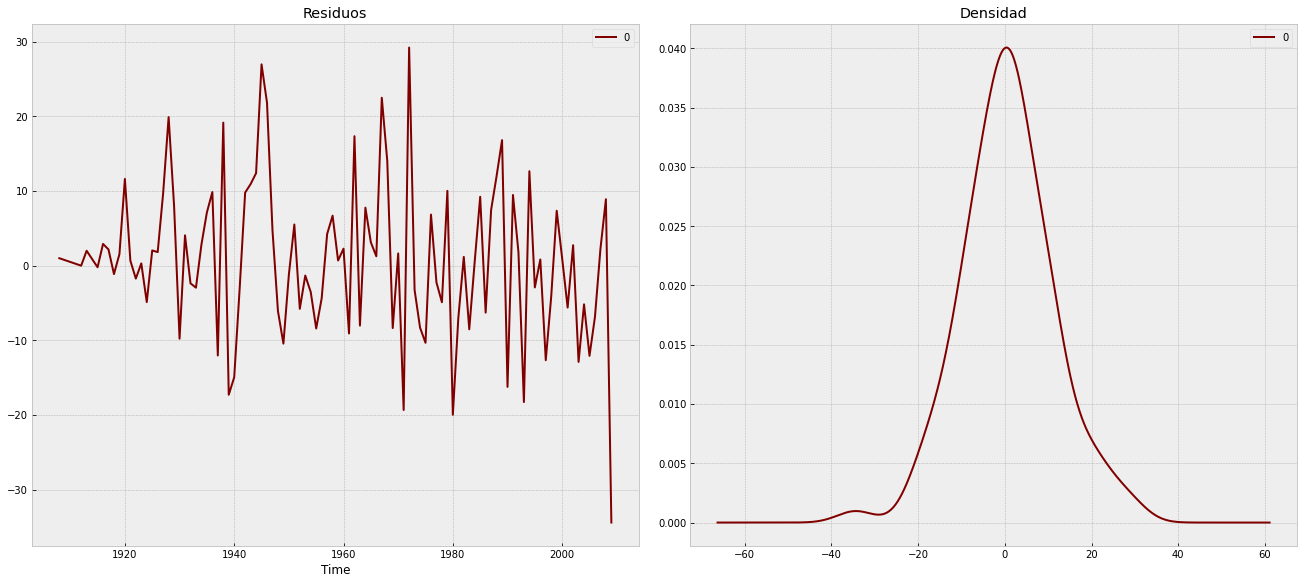

               0
count  98.000000
mean   0.638084 
std    10.561131
min   -34.423405
25%   -5.740865 
50%    0.892440 
75%    7.300648 
max    29.229967


In [67]:
#Se calcula para comprobar que no haya ningún patrón, es decir, media o varianza constante)
residuals = pd.DataFrame(results_autoARIMA_acc.resid)

fig, ax = plt.subplots(1, 2, figsize=(18, 8), constrained_layout=True)
residuals.plot(title='Residuos', ax=ax[0], color='maroon')
residuals.plot(kind='kde', title='Densidad', ax=ax[1], color='maroon')
ax[1].set_ylabel('')
plt.show()
print(residuals.describe())

<p align="justify">Por último, se muestra también la función de autocorrelación parcial de los residuos y se puede ver como tampoco se escapa ningún valor por fuera del área de significancia.</p>

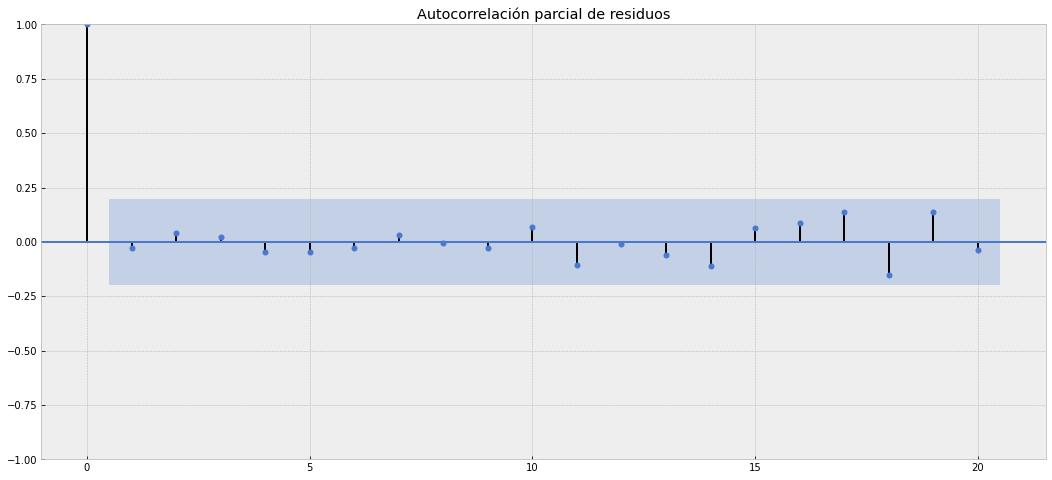

In [68]:
plot_pacf(residuals, title="Autocorrelación parcial de residuos");

#### Comparación de resultados

<p align="justify">A continuación, se muestra en una gráfica los distintos resultados de predicción obtenidos con los dos modelos creados anteriormente. Como se puede observar, se obtuvieron valores de predicción muy similares, habiendo hecho uso de un valor del parámetro <i>p</i> distinto para cada modelo. Sin embargo, el modelo con el que se consiguió un rmse más bajo fue el ARIMA alimentado con los parámetros calculados con las funciones de autocorrelación y autocorrelación parcial: <i>p</i> = 1, <i>d</i> = 1 y <i>q</i> = 1. </p>

Error ARIMA =  11.591581856596488
Error AutoARIMA =  11.626889657245831


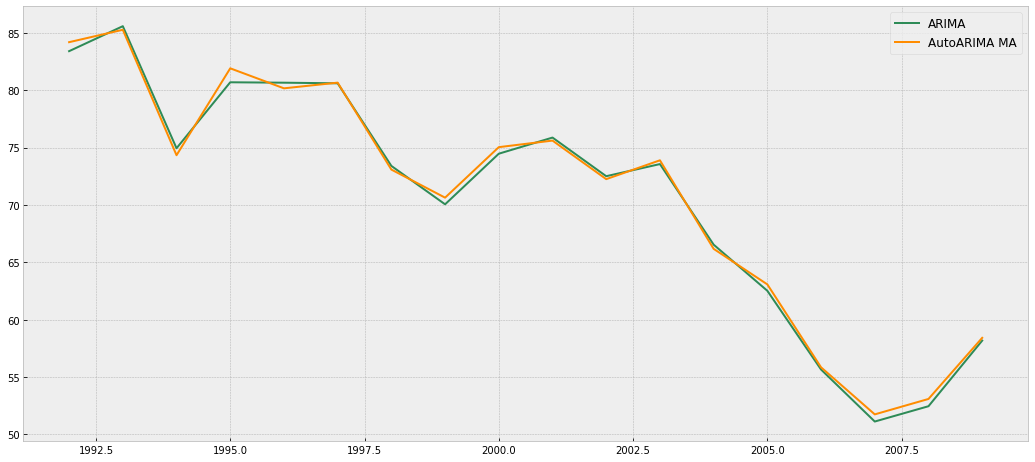

In [69]:
print("Error ARIMA = ", rmse_arima)
print("Error AutoARIMA = ", rmse_autoarima)
plt.figure(figsize=(18,8))    
plt.plot(results_AR_acc.fittedvalues.iloc[80:], color="seagreen", label='ARIMA')
plt.plot(results_autoARIMA_acc.fittedvalues.iloc[80:], color='darkorange', label='AutoARIMA MA')
plt.legend(fontsize=12)

### Conclusiones


<p align="justify">Después de haber realizado un estudio sobre esta serie temporal se han podido concluir varias cosas:</p>
<ol type="1" align="justify">
  <li>Es una serie temporal en la que se almacena información relativa a los accidentes aéreos desde 1908 hasta 2009.</li>
  <li>Se ha podido comprobar que, a medida que ha pasado el tiempo, los accidentes aéreos han ido disminuyendo, gracias a los avances tecnológicos y al aprendizaje de errores del pasado.</li>
  <li>Las dos zonas en las que más accidentes aéreos han ocurrido han sido Moscú, Rusia y Sao Paulo, Brasil. Gracias al breve sumario que nos ofrece cada uno de los registros, se ha podido ver claramente que estos accidentes no han tenido relación directa con el lugar de ocurrencia.</li>
  <li>La zona en la que ha habido más víctimas mortales de accidentes aéreos es la isla de Tenerife, puesto que, como se comentó anteriormente, en el trágico accidente de 1977 fallecieron 583 personas. Si a este número le sumamos las demás víctimas que haya podido haber en otros incidentes aéreos, Tenerife es el primero en el <i>top</i> de lugares con más fallecidos a sus espaldas.</li>
  <li>La aerolínea que ha propiciado más accidentes ha sido la compañía rusa <i>Aeroflot</i> y, además, también ha sido la que más fallecimientos ha causado, con un total de 7156.0 víctimas mortales.</li>
  <li>El modelo de avión con el que han ocurrido más accidentes ha sido el Douglas DC-3. Esto no ha sido porque el modelo hubiera salido fallido o fuera malo, sino que era el modelo más utilizado y más común del mercado y, por tanto, es lógico que más accidentes hayan sido causados con este modelo de aeronave.</li>
  <li>La serie temporal ha resultado ser no estacionaria, puesto que se ha comprobado que posee alguna raíz unitaria. Por tanto, ha sido necesario diferenciar la serie temporal para hacerla estacionaria. Además, se han calculado los parámetros <i>p</i> y <i>q</i> haciendo uso de las funciones de autocorrelación y autocorrelación parcial. Por otro lado, se ha hecho uso de la función <i>auto_arima</i> para calcular de otra manera los parámetros óptimos con los que alimentar el modelo. Debido a que con la opción manual y la automática se han conseguido valores de <i>p</i>, <i>d</i> y <i>q</i> muy similares (1,1,1 y 0,1,1) los resultados de los modelos también son muy parecidos.</li>
  <li>Si se centra el foco en la comparación de los resultados de los modelos con los valores originales, se puede ver que hay una ligera diferencia en los datos de predicción. Esto se debe a que, por definición, un accidente es un "<i>suceso imprevisto que altera la marcha normal o prevista de las cosas, especialmente el que causa daños a una persona o cosa</i>", es decir, es algo de lo que no se tienen datos exactos y en los que, además, participa el error humano, que es muy complicado de monitorizar y predecir. Por tanto, con los datos que se tienen sería muy complicado predecir cuántos accidentes ocurrirán en el futuro con exactitud.</li>
  <li>Una de las aproximaciones que se podrían hacer para dar lugar a predicciones más efectivas y útiles sería haciendo uso del porcentaje de accidentes por vuelos operados por año. De esta manera, sí que se podría estudiar mejor la evolución de los accidentes a lo largo de los años y se podría intentar predecir si en un futuro habrá cero accidentes aéreos por año.</li>
</ol>